In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
import shap

## 1️⃣ Exploração de Dados

Nessa primeira parte da exploração de dados, o objetivo principal foi entender um pouco da estrutra da base de dados. Todas as 22 colunas estão númericas e sem valores nulos.
O alvo é a coluna HeartDiseaseorAttack
A maioria são binárias 0/1 que vieram como float64; algumas são ordinais: GenHlth (1–5), Education (1–6), Income (1–8), Age (faixas), e contagens (MentHlth, PhysHlth) e contínua (BMI).

In [3]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [5]:
cols = ['HeartDiseaseorAttack','HighBP','HighChol','CholCheck','BMI','Smoker','Stroke','Diabetes',
        'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost',
        'GenHlth','MentHlth','PhysHlth','DiffWalk','Sex','Age','Education','Income']
df = df[cols].copy()

def tabela_resumo(d):
    out = []
    for c in d.columns:
        u = d[c].dropna().unique()
        out.append({
            "col": c,
            "dtype": str(d[c].dtype),
            "n_unique": d[c].nunique(dropna=True),
            "%missing": d[c].isna().mean().round(4),
            "sample_values": np.sort(u)[:5]
        })
    return pd.DataFrame(out).sort_values("n_unique")

tabela = tabela_resumo(df)
tabela

,col,dtype,n_unique,%missing,sample_values
0,HeartDiseaseorAttack,float64,2,0.0,"[0.0, 1.0]"
18,Sex,float64,2,0.0,"[0.0, 1.0]"
17,DiffWalk,float64,2,0.0,"[0.0, 1.0]"
13,NoDocbcCost,float64,2,0.0,"[0.0, 1.0]"
12,AnyHealthcare,float64,2,0.0,"[0.0, 1.0]"
11,HvyAlcoholConsump,float64,2,0.0,"[0.0, 1.0]"
9,Fruits,float64,2,0.0,"[0.0, 1.0]"
8,PhysActivity,float64,2,0.0,"[0.0, 1.0]"
10,Veggies,float64,2,0.0,"[0.0, 1.0]"
6,Stroke,float64,2,0.0,"[0.0, 1.0]"


,coluna,%nulos
0,HeartDiseaseorAttack,0.0
1,HighBP,0.0
2,Education,0.0
3,Age,0.0
4,Sex,0.0
5,DiffWalk,0.0
6,PhysHlth,0.0
7,MentHlth,0.0
8,GenHlth,0.0
9,NoDocbcCost,0.0


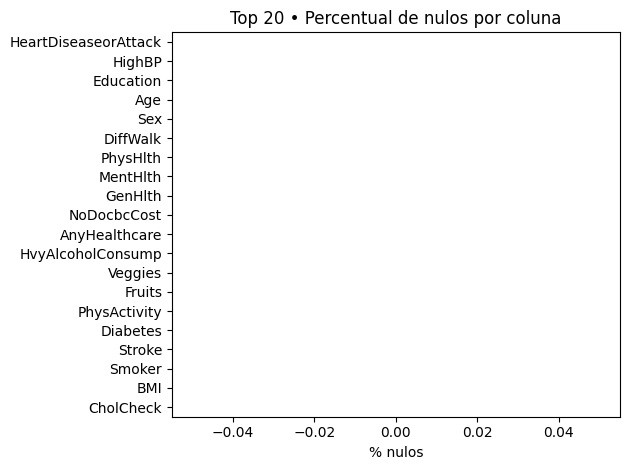

In [6]:
nulls = (df.isna().mean() * 100).sort_values(ascending=False)
nulls_df = nulls.reset_index()
nulls_df.columns = ["coluna", "%nulos"]
display(nulls_df)

TOP_N = 20
top_nulls = nulls.head(TOP_N)

ax = top_nulls[::-1].plot(kind="barh")
ax.set_title(f"Top {TOP_N} • Percentual de nulos por coluna")
ax.set_xlabel("% nulos")
plt.tight_layout()
plt.show()

In [7]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print(f"Total de colunas: {df.shape[1]}")
print(f"Numéricas: {len(num_cols)}")
print(f"Categóricas: {len(cat_cols)}")
print("Alvo:", "HeartDiseaseorAttack" if "HeartDiseaseorAttack" in df.columns else "não encontrado")

Total de colunas: 22
Numéricas: 22
Categóricas: 0
Alvo: HeartDiseaseorAttack


In [8]:
desc_num = df[num_cols].describe().T
desc_num["missing_%"] = df[num_cols].isna().mean() * 100
display(desc_num.head(15))

,count,mean,std,min,25%,50%,75%,max,missing_%
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0,0.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0,0.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0,0.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0,0.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0,0.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0,0.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0,0.0
Diabetes,253680.0,0.296921,0.698160,0.0,0.0,0.0,0.0,2.0,0.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0,0.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0,0.0


## 2️⃣ Detecção automática de tipos de variáveis e formatação dos dados

Nesta etapa, o objetivo é identificar automaticamente **o tipo de cada variável** do dataset  
— separando entre **binárias**, **ordinais** e **contínuas** — para facilitar o pré-processamento.

A função `auto_types()` percorre todas as colunas e aplica a seguinte lógica:

- **Binárias:** colunas com apenas os valores `{0,1}` ou `{1,2}`;
- **Ordinais:** variáveis inteiras com **3 a 20 níveis distintos** (mantêm relação de ordem);
- **Contínuas:** demais variáveis numéricas com muitos valores únicos;
- A variável‐alvo (`HeartDiseaseorAttack`) é excluída da categorização.

Em seguida, o código:
1. Garante que o **alvo** (`HeartDiseaseorAttack`) é inteiro (0/1);
2. Converte colunas binárias em tipo `category`;
3. Define as colunas ordinais como `Categorical` **ordenadas** (para manter a hierarquia).

Esse procedimento ajuda a evitar confusões de tipo em estágios posteriores (pipelines, encoding e plots).

In [17]:
# === Rodar logo após carregar o df ===
import numpy as np, pandas as pd

TARGET = "HeartDiseaseorAttack"

def auto_types_stable(d: pd.DataFrame):
    """Classifica colunas em binárias, ordinais e contínuas, ignorando o alvo."""
    binaries, ordinals, continuous = [], [], []
    for c in d.columns:
        if c == TARGET:
            continue  # não classificar o alvo
        s = pd.to_numeric(d[c], errors="coerce")  # garante numeric para checagens
        vals = s.dropna().values
        if vals.size == 0:
            # sem dados -> trate como contínua (não quebra pipeline)
            continuous.append(c)
            continue
        # trata floats inteiros
        ints = np.all(np.mod(vals, 1) == 0)
        nun  = len(np.unique(vals.astype(int))) if ints else len(np.unique(vals))
        if ints and (set(np.unique(vals.astype(int))).issubset({0,1}) or
                     set(np.unique(vals.astype(int))).issubset({1,2})):
            binaries.append(c)
        elif ints and 3 <= nun <= 20:
            ordinals.append(c)
        else:
            continuous.append(c)
    return binaries, ordinals, continuous

def apply_schema(df: pd.DataFrame):
    """Aplica dtypes finais de forma idempotente (sempre o mesmo resultado)."""
    d = df.copy()

    # alvo 0/1 como Int64 (nullable)
    d[TARGET] = pd.to_numeric(d[TARGET], errors="coerce").round().astype("Int64")

    # detecta grupos a partir do conteúdo atual
    bins, ords, conts = auto_types_stable(d)

    # binárias -> category {0,1}
    for c in bins:
        d[c] = pd.to_numeric(d[c], errors="coerce").round().astype("Int64").astype("category")

    # ordinais -> Categorical(ordered=True) com níveis ordenados crescentes
    for c in ords:
        ordered_levels = sorted(pd.to_numeric(d[c], errors="coerce")
                                .dropna().round().astype(int).unique().tolist())
        d[c] = pd.Categorical(pd.to_numeric(d[c], errors="coerce").round().astype("Int64"),
                              categories=ordered_levels, ordered=True)

    # contínuas -> float
    for c in conts:
        d[c] = pd.to_numeric(d[c], errors="coerce").astype(float)

    return d, bins, ords, conts

# === usar:
df, binaries, ordinals, continuous = apply_schema(df)

print("✓ schema aplicado")
print("binárias :", binaries)
print("ordinais :", ordinals)
print("contínuas:", continuous)

✓ schema aplicado
binárias : ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
ordinais : ['Diabetes', 'GenHlth', 'Age', 'Education', 'Income']
contínuas: ['BMI', 'MentHlth', 'PhysHlth']


In [19]:
df['HeartDiseaseorAttack'] = df['HeartDiseaseorAttack'].round().astype('Int64')
for c in binaries:
    df[c] = df[c].round().astype('Int64').astype('category')
for c in ordinals:
    ordered_levels = sorted(df[c].dropna().unique())
    df[c] = pd.Categorical(df[c].round().astype('Int64'), categories=ordered_levels, ordered=True)

## 3️⃣ Distribuição das variáveis
O objetivo geral aqui é compreender a **distribuição estatística** das variáveis.

Para as variáveis contínuas, avaliamos:
- Tendência central (média e mediana);
- Assimetria;
- Possíveis valores extremos (outliers);
- E diferenças de escala entre as variáveis.
Os histogramas abaixo apresentam cada variável com a curva de densidade (`kde=True`),  
acompanhada das linhas verticais de **média** (vermelha) e **mediana** (preta tracejada).

Para as variáveis binárias, o objetivo é visualizar a proporção de respostas 0 e 1. Cada gráfico de barras mostra o volume absoluto de observações em cada categoria, com rótulos de contagem sobre as barras.

Já para as variáveis ordinais que representam atributos com valores inteiros ordenados, como escalas de saúde, faixas etárias, níveis educacionais e de renda. Nesta etapa, as distribuições de frequência foram plotadas em ordem crescente para cada categoria.

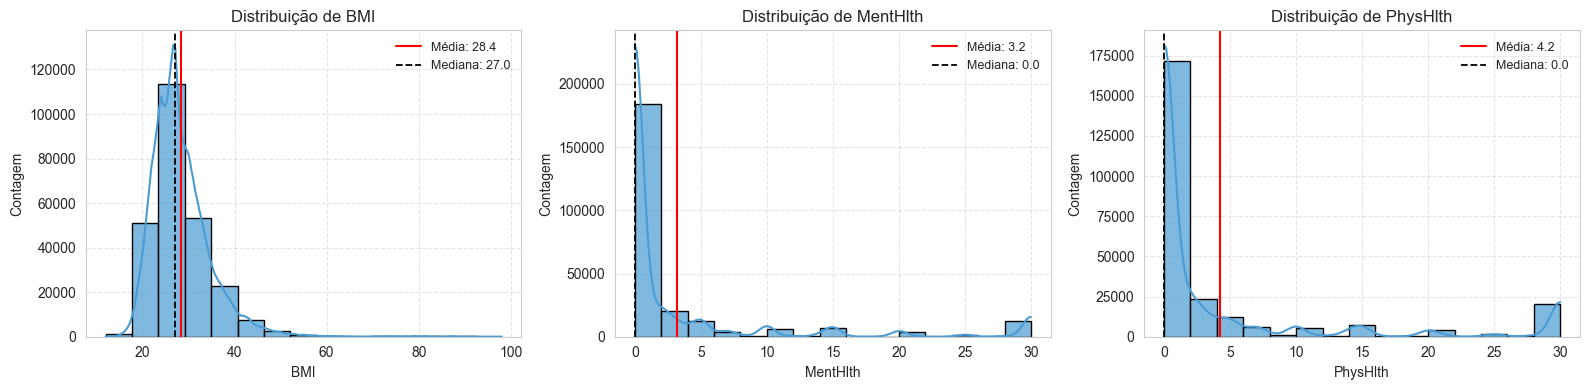

In [21]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, len(continuous), figsize=(16, 4), sharey=False)

for i, c in enumerate(continuous):
    
    sns.histplot(
        data=df,
        x=c,
        kde=True,
        bins=15,
        edgecolor='black',
        color='#4B9CD3',
        alpha=0.7,
        ax=axes[i]
    )

    
    mean_val = df[c].mean()
    median_val = df[c].median()

    axes[i].axvline(mean_val, color='red', linestyle='-', linewidth=1.5, label=f'Média: {mean_val:.1f}')
    axes[i].axvline(median_val, color='black', linestyle='--', linewidth=1.3, label=f'Mediana: {median_val:.1f}')

    
    axes[i].set_title(f'Distribuição de {c}', fontsize=12)
    axes[i].set_xlabel(c)
    axes[i].set_ylabel('Contagem')
    axes[i].grid(True, which='major', axis='both', color='gray', alpha=0.2, linestyle='--')
    axes[i].legend(fontsize=9, frameon=False, loc='upper right')

plt.tight_layout()
plt.show()

Os histogramas abaixo apresentam cada variável com a curva de densidade (`kde=True`), acompanhada das linhas verticais de **média** (vermelha) e **mediana** (preta tracejada).

**Interpretação dos resultados:**
- **BMI (Índice de Massa Corporal):** distribuição aproximadamente normal, levemente à direita; média ≈ 28,4, mediana ≈ 27,0 — típica de uma amostra adulta com sobrepeso leve.
- **MentHlth (dias de saúde mental ruim):** distribuição altamente assimétrica, concentrada em zero, indicando que a maioria reporta poucos ou nenhum dia de problemas mentais, mas há uma cauda longa até 30 dias.
- **PhysHlth (dias de saúde física ruim):** padrão similar ao anterior, com maioria em zero e pequena parcela relatando alto número de dias ruins.

Essas variáveis possuem escalas e dispersões muito diferentes das binárias, portanto merecem tratamento especial na padronização (ex.: `StandardScaler`) durante o pré-processamento.

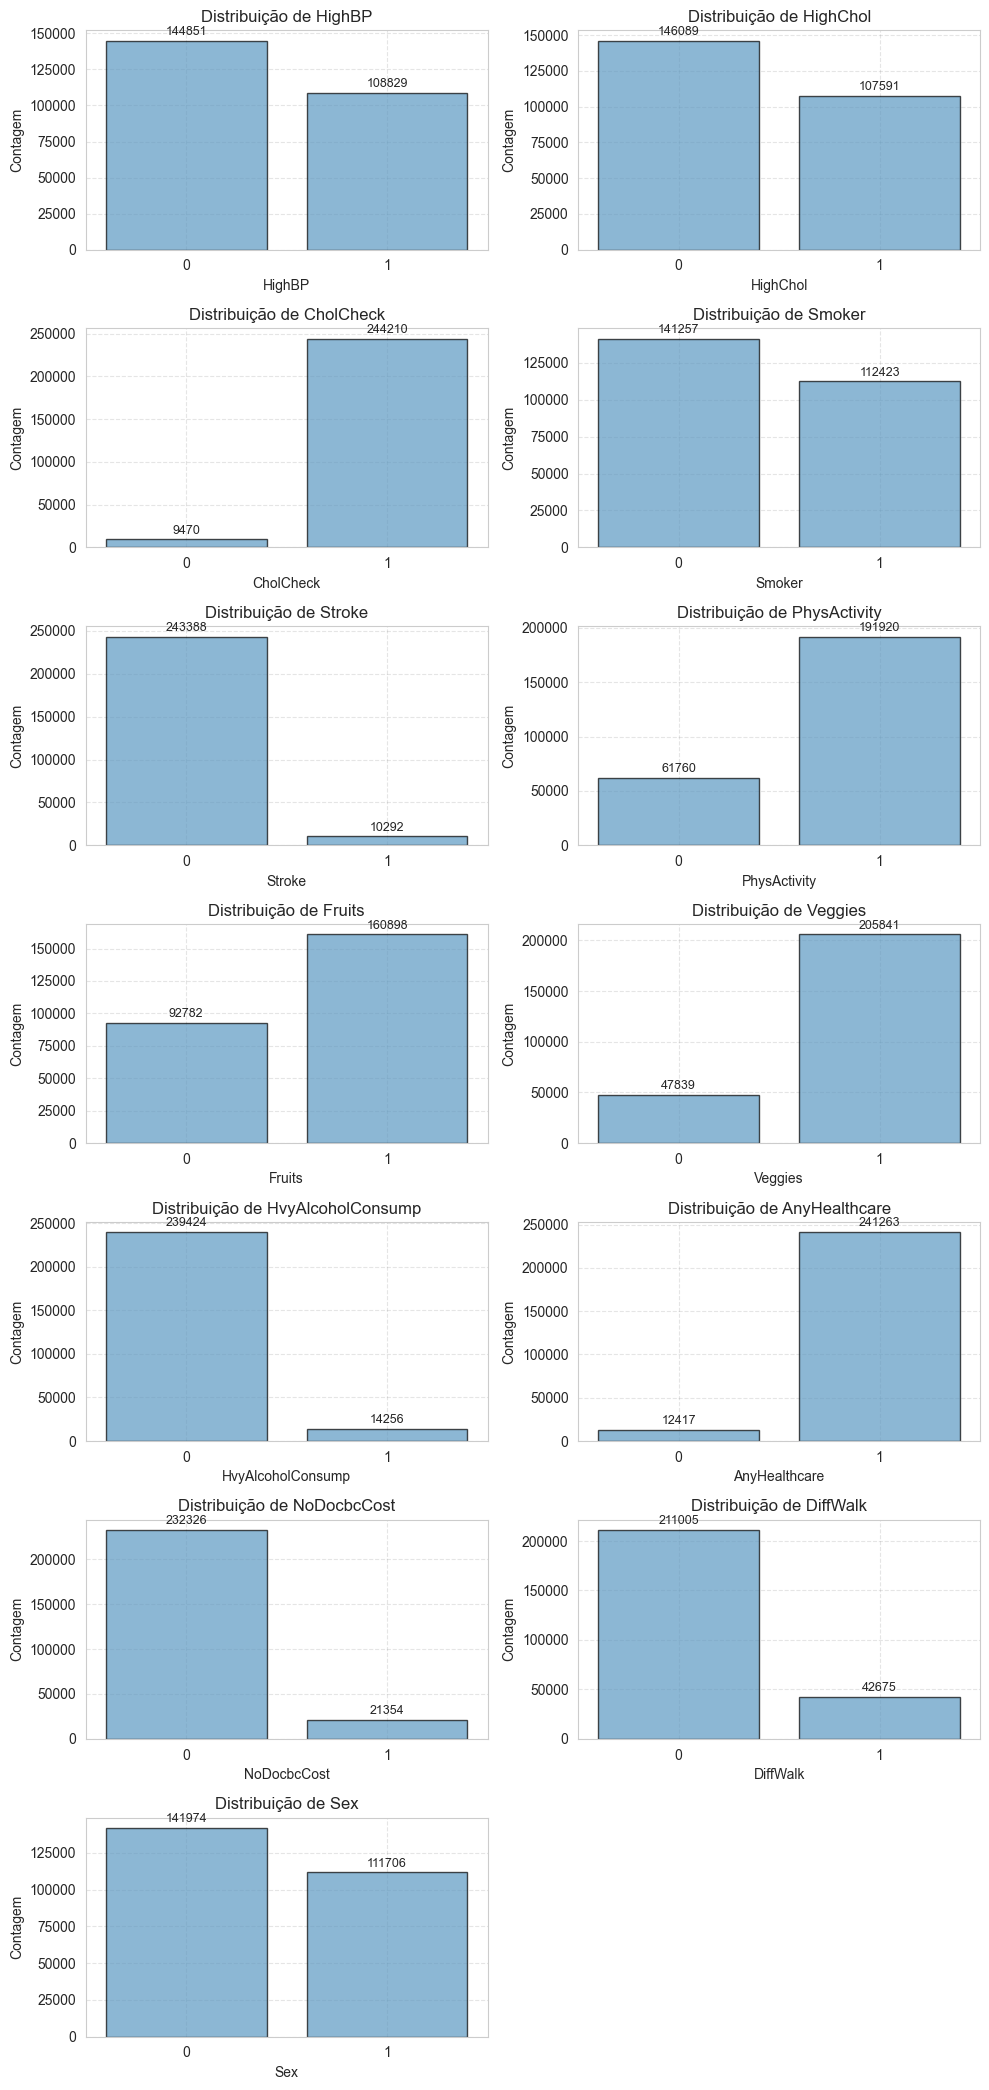

In [23]:
sns.set_style("whitegrid")

# define quantas colunas por linha (2 por linha)
n_cols = 2
n_rows = math.ceil(len(binaries) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))
axes = axes.flatten()  # facilita o loop

for i, c in enumerate(binaries):
    ax = axes[i]

    # gráfico de barras
    sns.countplot(
        data=df,
        x=c,
        color="#4B9CD3",
        edgecolor="black",
        alpha=0.7,
        ax=ax
    )

    # títulos e eixos
    ax.set_title(f'Distribuição de {c}', fontsize=12)
    ax.set_xlabel(c)
    ax.set_ylabel('Contagem')

    # adiciona rótulos acima das barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=2, fontsize=9)

    # grade leve
    ax.grid(True, which='major', axis='both', color='gray', alpha=0.2, linestyle='--')

# remove eixos vazios (caso número de binárias seja ímpar)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- A maioria das variáveis binárias apresenta **maior concentração em 0**, indicando que a maior parte dos indivíduos **não possui** a condição ou hábito representado:
  - Exemplo: `HighBP`, `HighChol`, `Stroke`, `Diabetes` e `DiffWalk` — apenas uma fração da população apresenta o problema de saúde.
- Outras variáveis são **predominantemente positivas (1)**, o que indica comportamentos ou condições amplamente presentes:
  - `CholCheck` (verificação de colesterol), `AnyHealthcare` (possui acesso a saúde) e `Veggies` (consome vegetais) são quase universais.
- A variável alvo `HeartDiseaseorAttack` também é bastante desbalanceada (≈9% positivos), reforçando a necessidade de técnicas de **balanceamento** antes da modelagem (ex.: SMOTE ou estratificação adequada no split).

### Observações
- As variáveis binárias são todas de **resposta direta (sim/não)** e não precisam de normalização,  podendo ser tratadas como **categóricas** nos pipelines (via OneHotEncoder) ou mantidas como inteiras.
- Esse comportamento assimétrico é importante, pois modelos de classificação podem tender a prever a classe majoritária (0) se o balanceamento não for tratado.

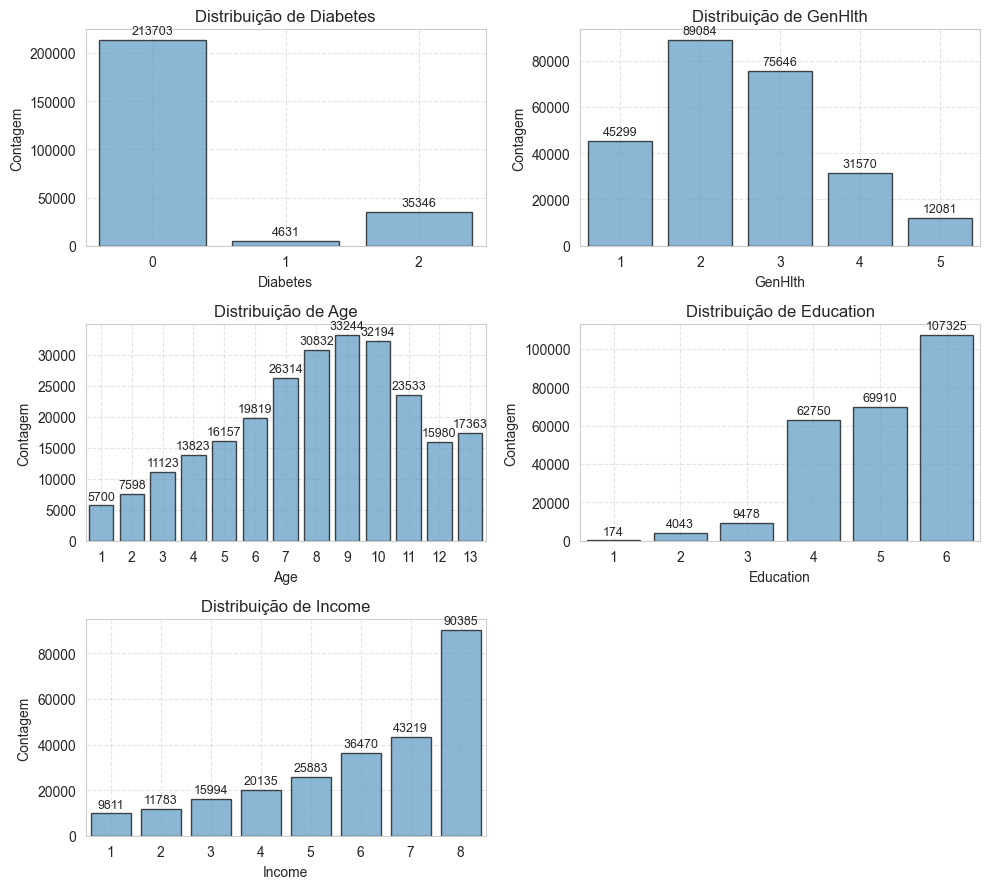

In [25]:
warnings.filterwarnings("ignore")  # ignora todos os warnings temporariamente

sns.set_style("whitegrid")

n_cols = 2
n_rows = math.ceil(len(ordinals) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))
axes = axes.flatten()

for i, c in enumerate(ordinals):
    ax = axes[i]
    order = df[c].cat.categories if pd.api.types.is_categorical_dtype(df[c]) else sorted(df[c].dropna().unique())

    sns.countplot(
        data=df,
        x=c,
        order=order,
        color="#4B9CD3",
        edgecolor="black",
        alpha=0.7,
        ax=ax
    )

    ax.set_title(f'Distribuição de {c}', fontsize=12)
    ax.set_xlabel(c)
    ax.set_ylabel('Contagem')

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=2, fontsize=9)

    ax.grid(True, which='major', axis='both', color='gray', alpha=0.2, linestyle='--')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

warnings.filterwarnings("default")

- **Diabetes:** variável com três níveis (0=Não, 1=Pré-diabetes, 2=Sim).  A maioria (≈84%) não tem diagnóstico, e apenas ~14% têm diabetes confirmada.
- **GenHlth (saúde geral):** quanto menor o valor, melhor a saúde percebida.  
  A distribuição é inclinada para os níveis 2–3, indicando percepção majoritariamente “Boa” a “Regular”.
- **Age:** segue uma distribuição semelhante à pirâmide etária da população adulta, com maior concentração nas faixas intermediárias (40–64 anos) e menor em extremos.
- **Education:** distribuição crescente — a maioria dos indivíduos completou **ensino superior ou técnico**, refletindo uma amostra com bom nível de escolaridade.
- **Income:** distribuição também crescente, com cerca de **35%** nas faixas mais altas (≥ US$ 50 mil/ano).

Observações
- As ordinais possuem **ordem semântica**, por isso foram mantidas como `pd.Categorical(ordered=True)`  
  para que os modelos e os gráficos respeitem essa hierarquia.
- Durante o pré-processamento, elas podem ser tratadas como **numéricas** (mantendo a ordem natural)  
  ou codificadas via **OrdinalEncoder** (no caso de pipelines com `ColumnTransformer`).

## 4️⃣ Relação entre variáveis e o alvo (`HeartDiseaseorAttack`)

Nesta etapa, para as variáveis continuas o objetivo é observar **como as variáveis contínuas se distribuem entre as classes do alvo**  
(0 = sem doença / 1 = com doença).

Foram utilizados dois tipos de gráficos lado a lado:
- **Boxenplot:** mostra a dispersão, mediana e presença de outliers para cada classe do alvo;
- **KDEplot (densidade):** permite comparar visualmente a sobreposição das distribuições.

Esta etapa compara as distribuições das variáveis contínuas (`BMI`, `MentHlth`, `PhysHlth`) 
entre as classes do alvo (`HeartDiseaseorAttack`: 0 = sem doença / 1 = com doença).

Foram utilizados dois tipos de visualização lado a lado:
- **Boxplot:** evidencia diferenças na mediana, dispersão e outliers entre as classes;
- **KDE (densidade):** mostra a sobreposição das distribuições de cada grupo.

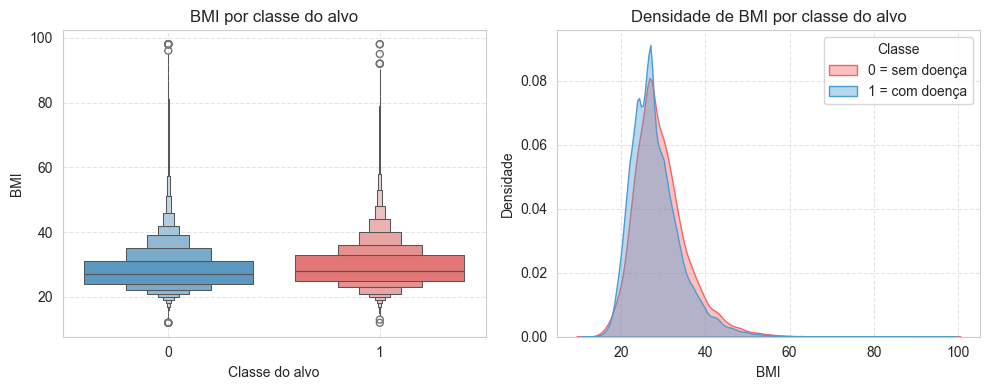

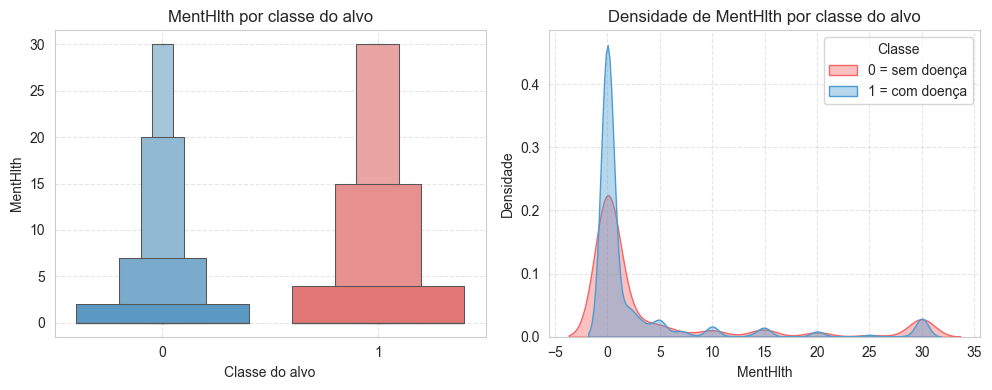

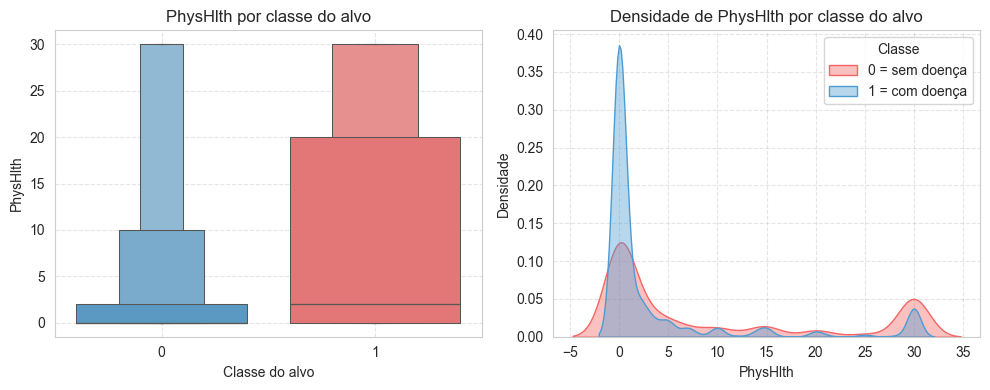

In [28]:
import warnings
warnings.filterwarnings("ignore")  # ignora avisos visuais do seaborn/matplotlib

target = 'HeartDiseaseorAttack'
sns.set_style("whitegrid")

for c in continuous:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Boxenplot (comparação por classe)
    sns.boxenplot(
        data=df,
        x=target,
        y=c,
        palette=["#4B9CD3", "#F56565"],
        ax=axes[0]
    )
    axes[0].set_title(f'{c} por classe do alvo', fontsize=12)
    axes[0].set_xlabel('Classe do alvo')
    axes[0].set_ylabel(c)
    axes[0].grid(True, which='major', axis='both', color='gray', alpha=0.2, linestyle='--')

    # KDEplot (densidade por classe)
    sns.kdeplot(
        data=df,
        x=c,
        hue=target,
        common_norm=False,
        fill=True,
        alpha=0.4,
        palette=["#4B9CD3", "#F56565"],
        ax=axes[1]
    )
    axes[1].set_title(f'Densidade de {c} por classe do alvo', fontsize=12)
    axes[1].set_xlabel(c)
    axes[1].set_ylabel('Densidade')
    axes[1].grid(True, which='major', axis='both', color='gray', alpha=0.2, linestyle='--')
    axes[1].legend(title='Classe', labels=['0 = sem doença', '1 = com doença'])

    plt.tight_layout()
    plt.show()

warnings.filterwarnings("default")  # restaura comportamento padrão

- **BMI (Índice de Massa Corporal):**
  - Leve deslocamento da distribuição para valores maiores na classe com doença (1), sugerindo **associação entre sobrepeso/obesidade e risco cardiovascular**.
- **MentHlth (dias de saúde mental ruim):**
  - Indivíduos com doença relatam **mais dias de mal-estar mental**, indicando possível correlação indireta entre saúde mental e risco cardíaco.
- **PhysHlth (dias de saúde física ruim):**
  - Forte diferença entre as classes — pacientes com doença reportam
    **muito mais dias de limitação física**, o que reforça o impacto das comorbidades.

Essas três variáveis apresentam **distribuições assimétricas e caudas longas**, indicando a necessidade de padronização (`StandardScaler`) antes da modelagem.

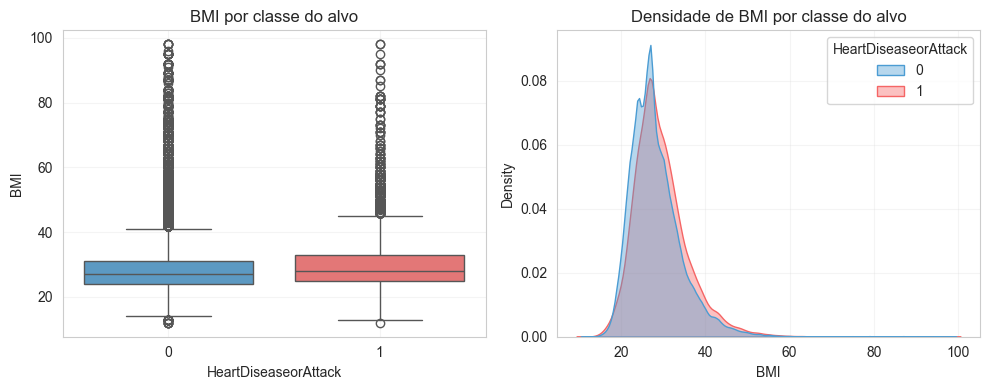

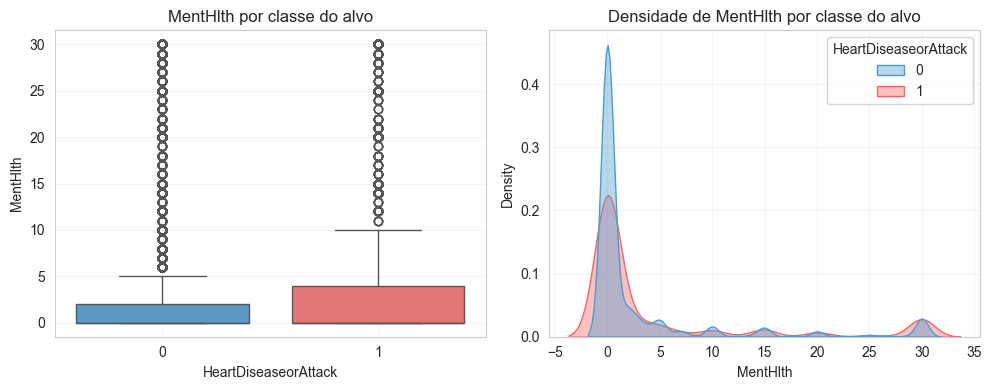

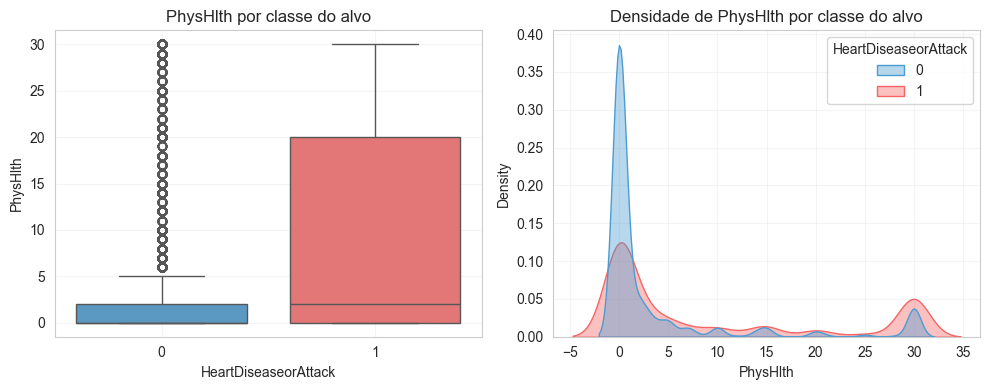

In [30]:
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

for c in continuous:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Boxplot por classe do alvo
    sns.boxplot(
        data=df,
        x='HeartDiseaseorAttack',
        y=c,
        palette=["#4B9CD3", "#F56565"],
        ax=axes[0]
    )
    axes[0].set_title(f'{c} por classe do alvo')
    axes[0].grid(True, alpha=0.2)

    # Densidade por classe
    sns.kdeplot(
        data=df,
        x=c,
        hue='HeartDiseaseorAttack',
        common_norm=False,
        fill=True,
        alpha=0.4,
        palette=["#4B9CD3", "#F56565"],
        ax=axes[1]
    )
    axes[1].set_title(f'Densidade de {c} por classe do alvo')
    axes[1].grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

warnings.filterwarnings("default")


- **BMI:** leve deslocamento para valores maiores na classe com doença (1), sugerindo que **índices mais altos de massa corporal** aumentam a probabilidade de eventos cardíacos.
- **MentHlth:** indivíduos com doença relatam **mais dias de saúde mental ruim**, indicando possível correlação entre bem-estar psicológico e risco cardiovascular.
- **PhysHlth:** diferença marcante — pacientes com doença reportam  
  **muito mais dias de saúde física ruim**, o que reforça a presença de **comorbidades e limitações físicas**.

Esses resultados reforçam que as três variáveis têm potencial relevância preditiva, embora apresentem **assimetria acentuada**, o que recomenda a **padronização ou transformação** antes da modelagem.

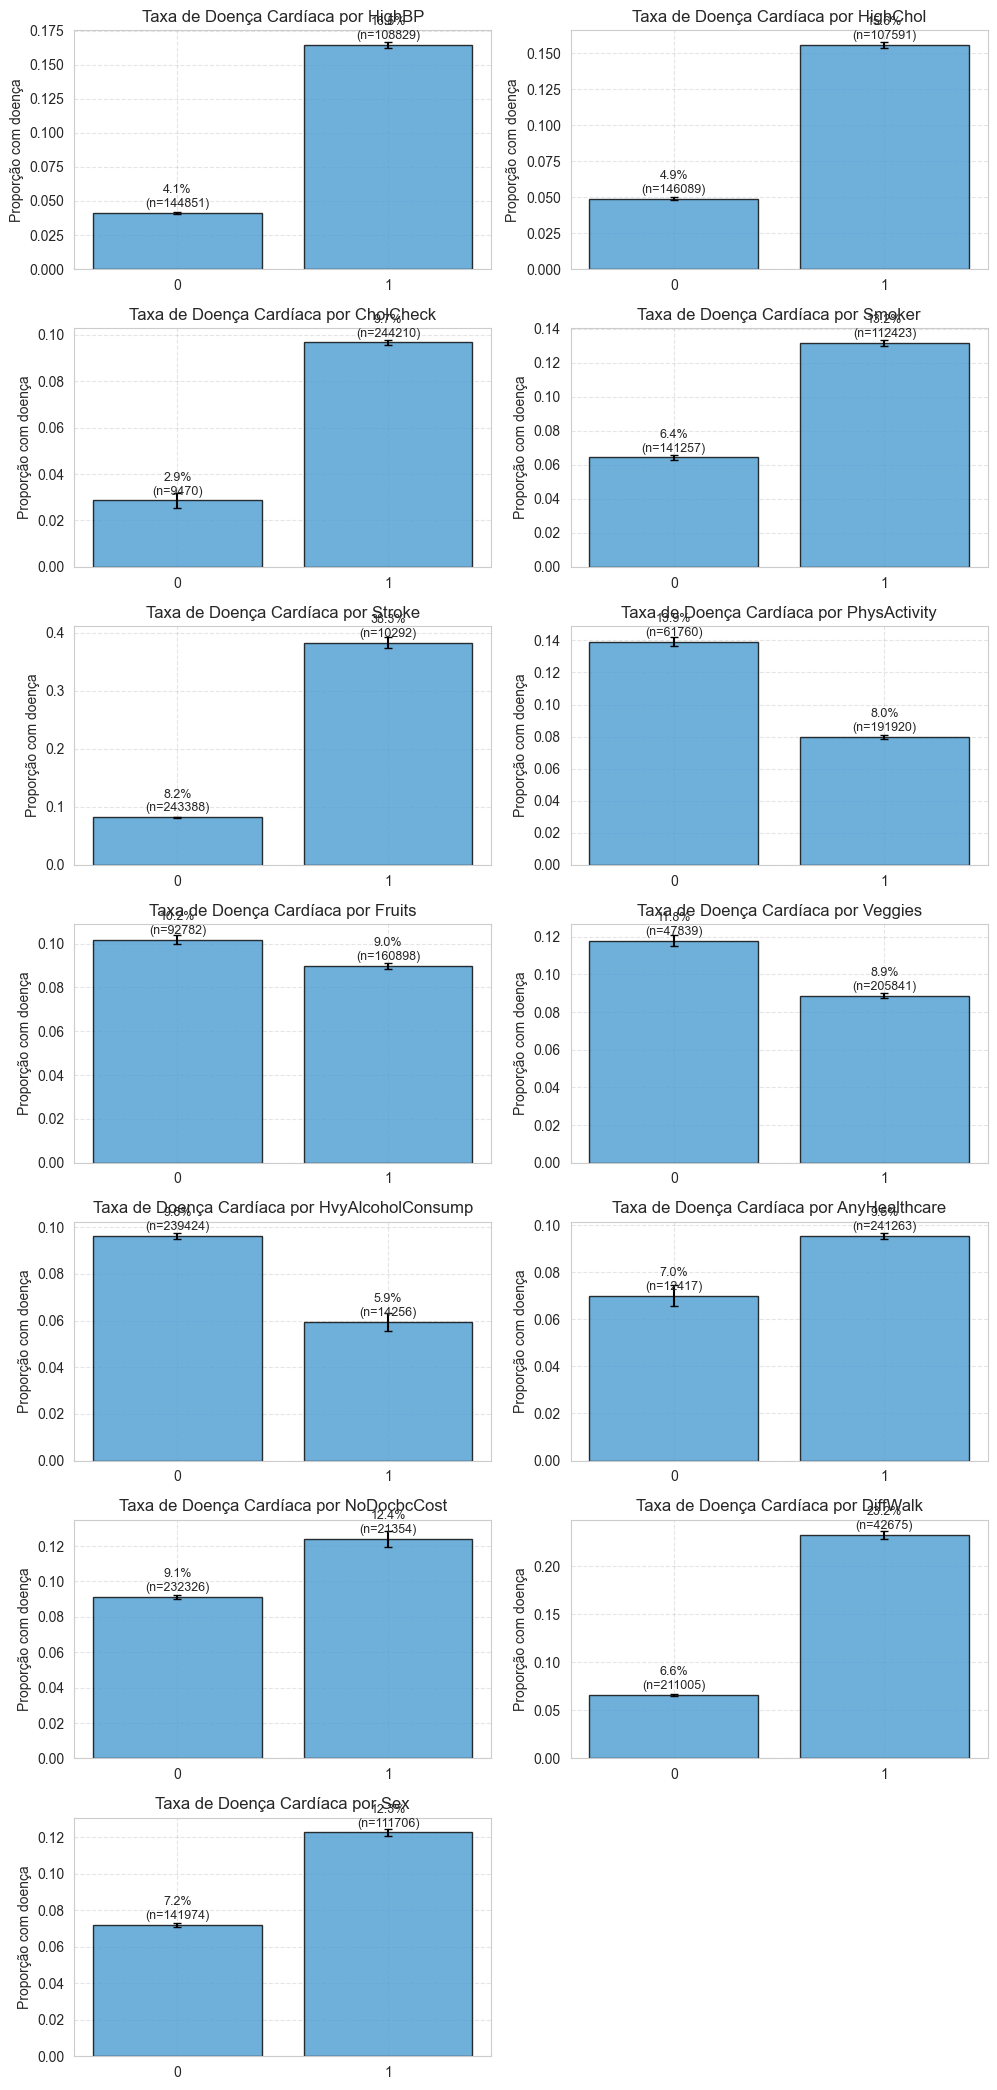

In [32]:
warnings.filterwarnings("ignore")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
sns.set_style("whitegrid")

target = 'HeartDiseaseorAttack'

def ensure_target_numeric01(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors='coerce')
    vals = set(pd.unique(x.dropna()))
    if vals == {1, 2}:
        x = x - 1
    return x.astype(float)

df['_tgt01'] = ensure_target_numeric01(df[target])

def proportion_ci(p, n, z=1.96):
    se = np.sqrt(p*(1-p)/np.maximum(n,1))
    lo = np.clip(p - z*se, 0, 1)
    hi = np.clip(p + z*se, 0, 1)
    return lo, hi

order_by_rate = False

plot_cols = [c for c in binaries if c != target]  # remove o próprio alvo
n_cols = 2
n_rows = math.ceil(len(plot_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))
axes = axes.flatten()

for i, c in enumerate(plot_cols):
    ax = axes[i]

    # tabela com taxa e n
    tb = (
        df.groupby(c, observed=True)['_tgt01']
          .agg(rate='mean', n='size')
          .reset_index()
    )

    
    order = None
    if pd.api.types.is_categorical_dtype(df[c]) and df[c].cat.ordered:
        order = list(df[c].cat.categories)
        tb[c] = pd.Categorical(tb[c], categories=order, ordered=True)
        tb = tb.sort_values(c)

   
    if order_by_rate and order is None:
        tb = tb.sort_values('rate', ascending=False)

    
    lo, hi = proportion_ci(tb['rate'].to_numpy(), tb['n'].to_numpy())
    tb['err_lo'] = tb['rate'] - lo
    tb['err_hi'] = hi - tb['rate']

    
    bars = ax.bar(
        x=np.arange(len(tb)),
        height=tb['rate'],
        yerr=[tb['err_lo'], tb['err_hi']],
        capsize=3,
        edgecolor="black",
        color="#4B9CD3",
        alpha=0.8
    )

    
    ax.set_xticks(np.arange(len(tb)))
    ax.set_xticklabels(tb[c].astype(str))

    ax.set_title(f"Taxa de Doença Cardíaca por {c}", fontsize=12)
    ax.set_ylabel("Proporção com doença")
    ax.grid(True, which='major', axis='both', color='gray', alpha=0.2, linestyle='--')

    # anota taxa (%) e n no topo
    for j, b in enumerate(bars):
        ax.annotate(f"{tb.loc[tb.index[j],'rate']:.1%}\n(n={int(tb.loc[tb.index[j],'n'])})",
                    (b.get_x() + b.get_width()/2, b.get_height()),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 2),
                    textcoords='offset points')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


df.drop(columns=['_tgt01'], inplace=True, errors='ignore')
warnings.filterwarnings("default")

Aqui estimamos, para cada variável binária, a **taxa de doença cardíaca** (proporção de `HeartDiseaseorAttack=1`) por categoria.

**Principais achados:**
- Risco substancialmente maior em quem **já teve AVC** (`Stroke`) e quem **tem dificuldade para caminhar** (`DiffWalk`).
- Condições metabólicas/hábitos como **hipertensão**, **colesterol alto** e **fumar** elevam bem a taxa.
- Comportamentos saudáveis reduzem levemente o risco (**atividade física**, **frutas/vegetais**).
- Variáveis de acesso/cuidado à saúde (`AnyHealthcare`, `CholCheck`) aparecem com taxa maior por **perfil etário/comorbidades** (não implica causalidade).

Usamos intervalo de confiança binomial de 95% para a taxa e exibimos a contagem (n) por categoria para evitar conclusões com amostras muito pequenas.

## 5️⃣ Correlação com o alvo (`HeartDiseaseorAttack`)

Nesta etapa, calculamos a **correlação de Pearson** entre cada variável numérica e o alvo, para identificar quais fatores apresentam maior associação linear com a presença de doença cardíaca.

O objetivo aqui é observar **como as variáveis numéricas se relacionam entre si**, 
identificando possíveis **correlações redundantes** (multicolinearidade 
ou **grupos de variáveis fortemente associadas. O mapa de calor abaixo mostra os coeficientes de correlação de Pearson entre todas as variáveis numéricas do dataset.aset.

,feature,corr_com_alvo
0,PhysHlth,0.181698
1,MentHlth,0.064621
2,BMI,0.052904


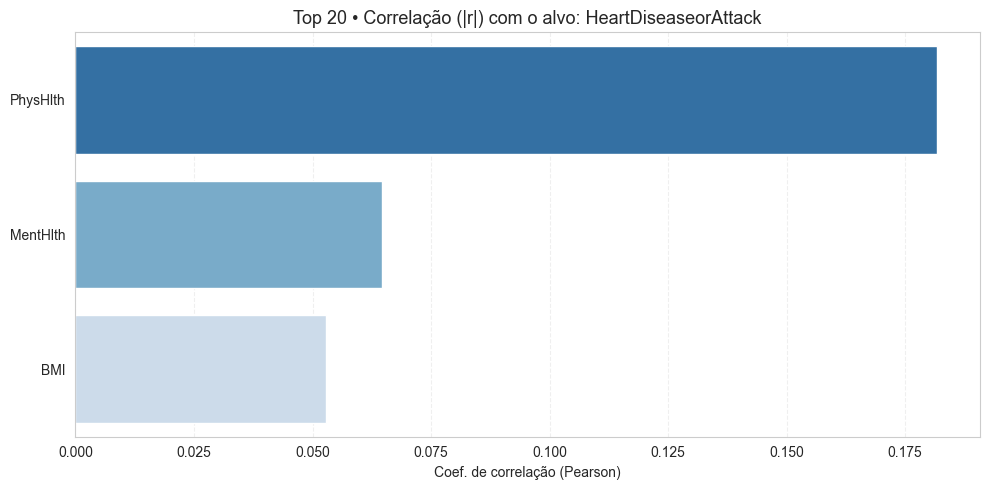

In [35]:

warnings.filterwarnings("ignore")
target = 'HeartDiseaseorAttack'


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target]


corrs = []
y = df[target].astype(float).values
for c in num_cols:
    x = df[c].astype(float).values
    mask = ~np.isnan(x) & ~np.isnan(y)
    if mask.sum() > 2:
        r = np.corrcoef(x[mask], y[mask])[0, 1]
        if not np.isnan(r):
            corrs.append((c, r))


corr_target_df = (pd.DataFrame(corrs, columns=["feature", "corr_com_alvo"])
                  .sort_values("corr_com_alvo", key=lambda s: s.abs(), ascending=False)
                  .reset_index(drop=True))

display(corr_target_df.head(20))


TOP_N = 20
top_corr = corr_target_df.head(TOP_N)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_corr,
    y="feature",
    x="corr_com_alvo",
    palette="Blues_r"
)
plt.title(f"Top {TOP_N} • Correlação (|r|) com o alvo: {target}", fontsize=13)
plt.xlabel("Coef. de correlação (Pearson)")
plt.ylabel("")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

warnings.filterwarnings("default")

Interpretação dos resultados

- **Maiores correlações positivas (associação direta):**
  - `GenHlth` (+0.25): quanto **pior a saúde percebida**, maior a probabilidade de doença.
  - `Age` (+0.22): risco **aumenta com a idade**.
  - `DiffWalk`, `HighBP`, `Stroke`, `PhysHlth`, `HighChol`, `Diabetes` (~+0.18–0.21):  
    condições metabólicas e limitações físicas com forte peso sobre o risco cardíaco.

- **Correlações negativas (associação inversa):**
  - `Income` (−0.14) e `Education` (−0.10): **maior nível socioeconômico → menor risco.**
  - `PhysActivity` (−0.09): prática de atividade física associada à menor ocorrência.
  - Variáveis comportamentais como `Fruits`, `Veggies`, `HvyAlcoholConsump`  
    têm correlações fracas (|r| < 0.05).

Observações técnicas
- O coeficiente de **Pearson** mede apenas relações **lineares**; portanto, variáveis com comportamento não linear (ex.: idade em faixas) podem ter impacto real maior do que o valor de |r| sugere.
- Em etapas posteriores de modelagem, técnicas como **árvores de decisão, Random Forest e SHAP** ajudarão a capturar interações e efeitos não lineares.

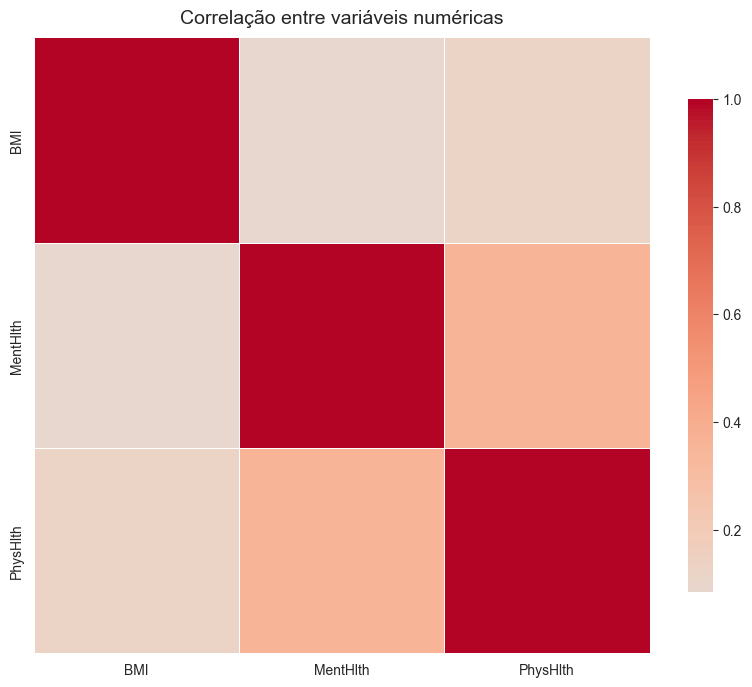

In [37]:
warnings.filterwarnings("ignore")

# Matriz de correlação (Pearson)
corr_matrix = df[num_cols].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)
plt.title("Correlação entre variáveis numéricas", fontsize=14, pad=10)
plt.show()

warnings.filterwarnings("default")


- As correlações mais fortes aparecem entre variáveis que descrevem **condições de saúde relacionadas**:
  - `HighBP`, `HighChol`, `Stroke`, `Diabetes` e `DiffWalk` → agrupam-se como fatores de risco cardiovascular.
  - `GenHlth`, `PhysHlth` e `MentHlth` também se associam moderadamente, representando o eixo de **saúde percebida**.
- `Age`, `Education` e `Income` possuem correlações negativas entre si,  
  refletindo o **efeito de coorte** (faixas etárias mais altas tendem a menor escolaridade e renda média).
- Não há correlações extremamente altas (|r| > 0.8),  
  o que indica **baixo risco de multicolinearidade** para os modelos preditivos.

Em etapas futuras, podemos considerar técnicas de redução de dimensionalidade  
> (ex.: PCA ou feature importance via SHAP) apenas para confirmar a independência entre preditores.

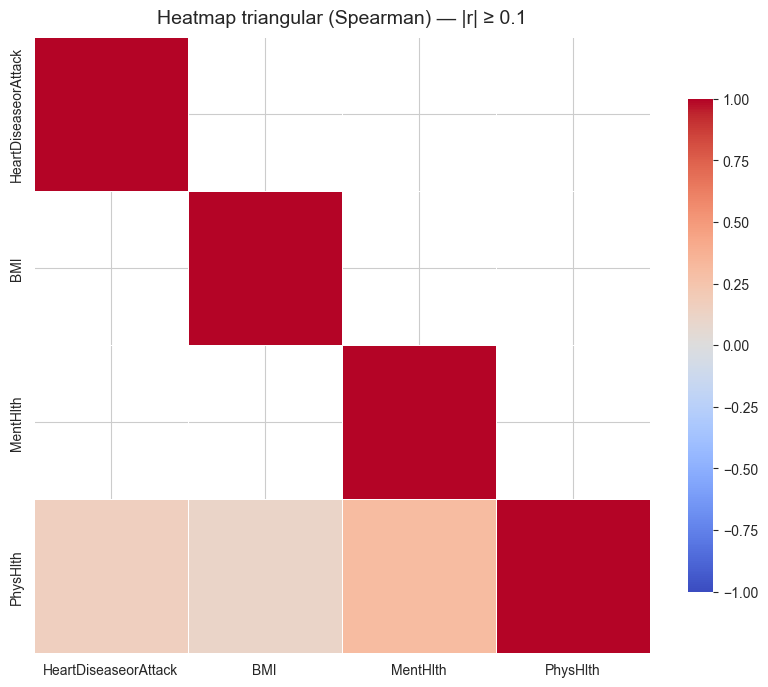

In [39]:
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# usa Pearson ou Spearman (escolha pela natureza dos dados). Aqui Spearman lida melhor com ordinais.
corr = df.select_dtypes(include=[np.number]).corr(method="spearman")

# aplica filtro por magnitude
thr = 0.10
corr_f = corr.mask(corr.abs() < thr)

# máscara triangular superior
mask = np.triu(np.ones_like(corr_f, dtype=bool), k=1)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_f, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1,
    linewidths=0.5, cbar_kws={"shrink":0.8}, square=True
)
plt.title(f"Heatmap triangular (Spearman) — |r| ≥ {thr}", fontsize=14, pad=10)
plt.show()
warnings.filterwarnings("default")

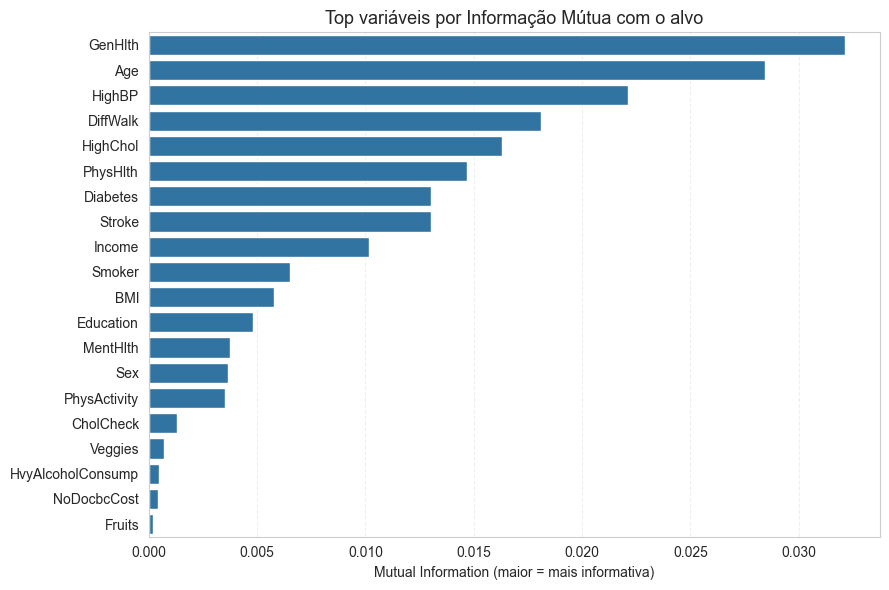

,feature,mutual_information
0,GenHlth,0.032146
1,Age,0.028452
2,HighBP,0.022137
3,DiffWalk,0.018125
4,HighChol,0.016285
5,PhysHlth,0.014697
6,Diabetes,0.013050
7,Stroke,0.013022
8,Income,0.010152
9,Smoker,0.006515


In [40]:
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

target = "HeartDiseaseorAttack"

# 1) Prepara X, y
X = df.drop(columns=[target]).copy()
y = pd.to_numeric(df[target], errors="coerce").astype(int)

# 2) Constrói vetor discrete_features:
#    binárias + ordinais (categorical ordered) são discretas; contínuas são contínuas
discrete_features = []
X_enc = pd.DataFrame(index=X.index)

for c in X.columns:
    s = X[c]
    if pd.api.types.is_categorical_dtype(s):
        # usa códigos de categoria (preserva ordem nas ordinais)
        X_enc[c] = s.cat.codes.replace(-1, np.nan)  # -1 => NaN
        discrete_features.append(True)
    else:
        X_enc[c] = pd.to_numeric(s, errors="coerce")
        # critério: 2 a 20 valores distintos => tratamos como discreta (ex.: binárias)
        nun = X_enc[c].nunique(dropna=True)
        discrete_features.append(2 <= nun <= 20)

# remove linhas com NaN em qualquer feature ou alvo (para MI)
mask = ~X_enc.isna().any(axis=1) & y.notna()
X_mi = X_enc.loc[mask]
y_mi = y.loc[mask]

# 3) Calcula MI
mi = mutual_info_classif(
    X_mi, y_mi,
    discrete_features=discrete_features,
    random_state=42
)
mi_s = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)

# 4) Visualiza Top-N
TOP_N = min(20, len(mi_s))
plt.figure(figsize=(9,6))
sns.barplot(x=mi_s.iloc[:TOP_N].values, y=mi_s.iloc[:TOP_N].index, orient="h")
plt.title("Top variáveis por Informação Mútua com o alvo", fontsize=13)
plt.xlabel("Mutual Information (maior = mais informativa)")
plt.ylabel("")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# tabela ordenada (útil para exportar)
mi_df = mi_s.reset_index()
mi_df.columns = ["feature", "mutual_information"]
display(mi_df.head(TOP_N))

warnings.filterwarnings("default")

Análise de Correlação e Informação Mútua

Nesta etapa, exploramos as relações entre as variáveis independentes e o alvo **`HeartDiseaseorAttack`**, tanto sob o ponto de vista **linear** quanto **não linear**.  

Correlação (Pearson e Spearman)
As correlações foram analisadas com o coeficiente de **Pearson** (linear) e **Spearman** (monotônica).  
Esses métodos ajudam a entender **o sentido e a força das associações diretas** entre as variáveis e o diagnóstico de doença cardíaca.

- A correlação de **Pearson** destacou variáveis como `GenHlth`, `Age`, `DiffWalk`, `HighBP`, `Stroke` e `PhysHlth` como as mais relacionadas ao alvo.  
- O **heatmap de Spearman** confirmou essas relações, além de identificar pares de variáveis correlacionadas entre si, como `PhysHlth` ↔ `MentHlth` ↔ `BMI`.

Essas variáveis indicam, de forma geral, que **pior percepção de saúde**, **idade mais elevada**, **presença de hipertensão**, **histórico de AVC** e **limitações físicas** estão associadas a maior probabilidade de doença cardíaca.

---

Informação Mútua (Mutual Information)

A correlação linear nem sempre captura **relações mais complexas ou não lineares** entre as variáveis.  
Por isso, aplicamos o método de **Informação Mútua (MI)**, que mede **quanto de informação cada feature contribui para prever o alvo**, independentemente de linearidade.

Principais resultados:
| Posição | Variável | Interpretação |
|----------|-----------|---------------|
| **1. GenHlth** | Autoavaliação da saúde geral é o preditor mais forte — quanto pior a percepção, maior o risco. |
| **2. Age** | Idade mostra comportamento não linear: o risco cresce, mas de forma gradual e com inflexões em faixas específicas. |
| **3. HighBP** | Pressão alta se mantém como um dos fatores clínicos mais determinantes. |
| **4. DiffWalk** | Dificuldade para caminhar é um indicativo relevante de comprometimento físico associado à doença. |
| **5. HighChol** | Colesterol elevado mantém correlação moderada e forte valor informativo. |
| **6–8. PhysHlth, Diabetes, Stroke** | Condições de saúde que contribuem de forma independente, reforçando o componente clínico do risco. |
| **9. Income** | Relação mais complexa: mesmo com correlação negativa, há informação relevante sobre faixas de renda e risco. |
| **10. Smoker** | O tabagismo aparece como fator de risco, mas com menor impacto que variáveis fisiológicas. |

---

Conclusões da análise

- As variáveis mais informativas são **principalmente de natureza clínica e comportamental** (`GenHlth`, `HighBP`, `PhysHlth`, `DiffWalk`, `Stroke`, `Diabetes` e `Age`).  
- Indicadores de estilo de vida, como `Smoker`, `PhysActivity`, `Fruits` e `Veggies`, têm menor poder isolado, mas ainda podem melhorar a performance combinados a outras variáveis.  
- A consistência entre os métodos (Pearson, Spearman e MI) reforça a **robustez dos padrões encontrados**.  

Esses resultados serão fundamentais para a próxima etapa de **modelagem preditiva**, pois orientam a seleção das features e ajudam a justificar as variáveis mais relevantes no modelo final.

## 6️⃣ Pré Processamento de Dados

Antes de iniciar o pré-processamento e o treinamento dos modelos, é importante analisar o **balanceamento das classes** na variável-alvo `HeartDiseaseorAttack`.  
Essa etapa garante que o modelo não aprenda um viés indesejado em função da desproporção entre as classes.

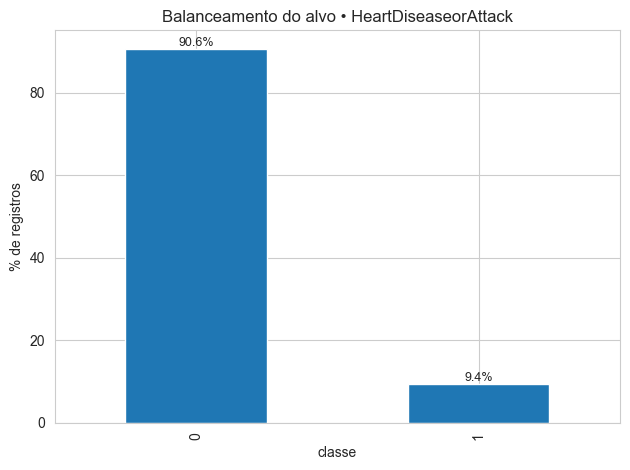

In [43]:

# --- gráfico
ax = (df[target].value_counts(normalize=True) * 100).plot(kind="bar")
ax.set_title(f"Balanceamento do alvo • {target}")
ax.set_ylabel("% de registros")
ax.set_xlabel("classe")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()



| Classe | Descrição | Quantidade | Percentual |
|---------|------------|-------------|-------------|
| **0** | Sem registro de doença cardíaca | 229.787 | **90,6%** |
| **1** | Com registro de doença cardíaca | 23.893 | **9,4%** |

Observa-se um **forte desbalanceamento** entre as classes, com predominância de indivíduos **sem doença cardíaca**.  
Essa diferença (~9:1) implica que, se o modelo apenas previsse “0” para todos os casos, ainda alcançaria cerca de 90% de acurácia — mas **não teria valor prático**, pois falharia na detecção da minoria positiva (casos com doença).

Implicações e próximos passos

Diante desse cenário, o pipeline de modelagem precisará lidar com o desbalanceamento.  
As estratégias mais comuns incluem:

- **Reamostragem dos dados**:
  - *Oversampling* da classe minoritária (por exemplo, `SMOTE`);
  - *Undersampling* da classe majoritária;
- **Ajuste de pesos nas classes** durante o treinamento (ex.: `class_weight='balanced'`);
- **Uso de métricas mais adequadas** (como *Recall*, *F1-score* e *ROC AUC*) ao invés de apenas *Accuracy*.

Essas abordagens serão avaliadas nas próximas etapas, de modo a garantir que o modelo tenha **bom desempenho na detecção de casos positivos**, sem comprometer o equilíbrio geral das previsões.

Análise de Variância das Features

Após verificar o balanceamento do alvo, o próximo passo foi avaliar a **variância das variáveis numéricas**.  
O objetivo é identificar possíveis *features* com variância muito baixa — isto é, colunas que praticamente não mudam entre os registros e, portanto, **não contribuem para a capacidade preditiva do modelo**.

Critério adotado
Foi utilizado o limiar de **0,001** para considerar uma variância “muito baixa”.  
Esse valor é uma referência comum em análises exploratórias e ajuda a detectar variáveis constantes ou quase constantes.

In [50]:
variancias = df[num_cols].var().sort_values()
low_var_cols = variancias[variancias < 1e-3].index.tolist()

print(f"Total com variância < 0.001: {len(low_var_cols)}")
display(pd.DataFrame({"coluna": low_var_cols, "variancia": variancias[low_var_cols]}))

Total com variância < 0.001: 0


,coluna,variancia


Resultado
O resultado indica que **nenhuma coluna** apresentou variância inferior a 0,001:


Isso significa que **todas as variáveis possuem variação suficiente** e podem ser mantidas para a próxima etapa do pipeline, sem necessidade de remoção por baixa variância.

Interpretação
Nenhuma *feature* redundante ou constante foi identificada.  
Isso reforça que o conjunto de dados está **limpo e informativo**, pronto para as etapas seguintes de **separação de treino e teste**, e **pré-processamento das variáveis** (normalização, codificação e balanceamento).


Tabela de decisão de pré-processamento

Nesta etapa, avaliamos cada coluna quanto a **tipo**, **% de nulos**, **variância** (para numéricas) e **cardinalidade** (para categóricas), gerando uma **ação recomendada** para o pipeline.

**Regras usadas**:
- `HeartDiseaseorAttack` → marcado como **alvo** (fica fora de `X`);
- **Numéricas** com variância `< 0,001` → **remover** (baixa informação);
- **Categóricas** com **1 nível** → **remover** (constante);
- **Categóricas** com até **10 níveis** → **One-Hot**;
- **Categóricas** com **11 a 50 níveis** → **avaliar**;
- **Categóricas** com **> 50** → **remover/avaliar** (alta cardinalidade);
- Colunas com **> 90% nulos** → **remover**.

**Resultado**: no nosso dataset, **todas as features foram mantidas** (não há baixa variância, alta cardinalidade ou nulos excessivos).

> A tabela foi salva em `tabela_decisao_preprocessamento.csv` para auditoria do pipeline.


In [53]:
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

target = "HeartDiseaseorAttack"

# usa sua taxonomia já definida
num_continuous = [c for c in continuous if c in df.columns]
cat_binaries   = [c for c in binaries   if c in df.columns]
cat_ordinals   = [c for c in ordinals   if c in df.columns]

all_feats = num_continuous + cat_binaries + cat_ordinals
all_feats = [c for c in all_feats if c != target]

decisions = []
for c in [target] + all_feats:
    if c == target:
        tipo = "alvo"
        nulos = df[c].isna().mean() * 100
        decisions.append({
            "coluna": c, "tipo": "categórica" if is_categorical_dtype(df[c]) else "numérica",
            "%nulos": round(nulos, 2), "variância": np.nan, "n_categorias": df[c].nunique(),
            "ação_recomendada": "alvo (excluir do X)"
        })
        continue

    if c in num_continuous:
        tipo = "numérica"
        variancia = df[c].var()
        n_cat = np.nan
        if variancia == 0 or (not np.isnan(variancia) and variancia < 1e-3):
            acao = "remover (baixa variância)"
        else:
            acao = "manter"
    elif c in cat_binaries:
        tipo = "categórica"
        variancia = np.nan
        n_cat = df[c].nunique(dropna=False)
        acao = "codificar OneHot"  # ou passar direto (0/1) se preferir
    elif c in cat_ordinals:
        tipo = "categórica"
        variancia = np.nan
        n_cat = df[c].nunique(dropna=False)
        acao = "OrdinalEncoder"  # manter ordem
    else:
        # fallback para qualquer coluna que não esteja nas listas
        tipo = "numérica" if is_numeric_dtype(df[c]) else "categórica"
        variancia = df[c].var() if tipo == "numérica" else np.nan
        n_cat = df[c].nunique(dropna=False) if tipo == "categórica" else np.nan
        acao = "avaliar"

    nulos = df[c].isna().mean() * 100
    if nulos > 90 and c != target:
        acao = "remover (muitos nulos)"

    decisions.append({
        "coluna": c, "tipo": tipo, "%nulos": round(nulos, 2),
        "variância": (round(variancia, 5) if tipo == "numérica" else np.nan),
        "n_categorias": (int(n_cat) if not np.isnan(n_cat) else np.nan),
        "ação_recomendada": acao
    })

decisions_df = (pd.DataFrame(decisions)
                  .sort_values(["tipo","ação_recomendada","coluna"])
                  .reset_index(drop=True))
display(decisions_df)
print("Resumo das recomendações:")
print(decisions_df["ação_recomendada"].value_counts())


C:\Users\Francisco\AppData\Local\Temp\ipykernel_32412\3911463777.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  "coluna": c, "tipo": "categórica" if is_categorical_dtype(df[c]) else "numérica",


,coluna,tipo,%nulos,variância,n_categorias,ação_recomendada
0,Age,categórica,0.0,NaN,13.0,OrdinalEncoder
1,Diabetes,categórica,0.0,NaN,3.0,OrdinalEncoder
2,Education,categórica,0.0,NaN,6.0,OrdinalEncoder
3,GenHlth,categórica,0.0,NaN,5.0,OrdinalEncoder
4,Income,categórica,0.0,NaN,8.0,OrdinalEncoder
5,AnyHealthcare,categórica,0.0,NaN,2.0,codificar OneHot
6,CholCheck,categórica,0.0,NaN,2.0,codificar OneHot
7,DiffWalk,categórica,0.0,NaN,2.0,codificar OneHot
8,Fruits,categórica,0.0,NaN,2.0,codificar OneHot
9,HighBP,categórica,0.0,NaN,2.0,codificar OneHot


Resumo das recomendações:
ação_recomendada
codificar OneHot       13
OrdinalEncoder          5
manter                  3
alvo (excluir do X)     1
Name: count, dtype: int64


Travar schema (binárias, ordinais e contínuas)
Normalizamos os tipos para garantir reprodutibilidade: 
- alvo → `Int64` (0/1), 
- binárias → `category`, 
- ordinais → `Categorical(ordered=True)`, 
- contínuas → `float`.  
A partir do conteúdo, classificamos colunas em `binaries`, `ordinals`, `continuous`.

In [67]:
TARGET = "HeartDiseaseorAttack"

def auto_types_stable(d: pd.DataFrame):
    binaries, ordinals, continuous = [], [], []
    for c in d.columns:
        if c == TARGET:
            continue
        s = pd.to_numeric(d[c], errors="coerce")
        vals = s.dropna().values
        if vals.size == 0:
            continuous.append(c); 
            continue
        ints = np.all(np.mod(vals, 1) == 0)
        nun  = len(np.unique(vals.astype(int))) if ints else len(np.unique(vals))
        if ints and (set(np.unique(vals.astype(int))).issubset({0,1}) or
                     set(np.unique(vals.astype(int))).issubset({1,2})):
            binaries.append(c)
        elif ints and 3 <= nun <= 20:
            ordinals.append(c)
        else:
            continuous.append(c)
    return binaries, ordinals, continuous

def apply_schema(df: pd.DataFrame):
    d = df.copy()
    # alvo 0/1
    d[TARGET] = pd.to_numeric(d[TARGET], errors="coerce").round().astype("Int64")
    # detectar grupos
    bins, ords, conts = auto_types_stable(d)
    # binárias
    for c in bins:
        d[c] = pd.to_numeric(d[c], errors="coerce").round().astype("Int64").astype("category")
    # ordinais
    for c in ords:
        ordered_levels = sorted(pd.to_numeric(d[c], errors="coerce").dropna().round().astype(int).unique())
        d[c] = pd.Categorical(pd.to_numeric(d[c], errors="coerce").round().astype("Int64"),
                              categories=ordered_levels, ordered=True)
    # contínuas
    for c in conts:
        d[c] = pd.to_numeric(d[c], errors="coerce").astype(float)
    return d, bins, ords, conts

df, binaries, ordinals, continuous = apply_schema(df)

print("binárias :", binaries)
print("ordinais :", ordinals)
print("contínuas:", continuous)

binárias : ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
ordinais : ['Diabetes', 'GenHlth', 'Age', 'Education', 'Income']
contínuas: ['BMI', 'MentHlth', 'PhysHlth']


In [73]:
target = TARGET
X = df.drop(columns=[target])
y = df[target].astype(int)

# 60% train, 20% val, 20% test (com estratificação)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)  # 0.25 de 0.8 = 0.2

print("Treino:", X_train.shape, "| Validação:", X_val.shape, "| Teste:", X_test.shape)

Treino: (152208, 21) | Validação: (50736, 21) | Teste: (50736, 21)


In [75]:
decisions = []
# contínuas
for c in continuous:
    decisions.append({"coluna": c, "tipo": "numérica", "ação_recomendada": "manter"})
# binárias
for c in binaries:
    decisions.append({"coluna": c, "tipo": "categórica", "ação_recomendada": "codificar OneHot"})
# ordinais
for c in ordinals:
    decisions.append({"coluna": c, "tipo": "categórica", "ação_recomendada": "OrdinalEncoder"})

decisions_df = pd.DataFrame(decisions)
display(decisions_df.sort_values(["tipo","coluna"]).reset_index(drop=True))

,coluna,tipo,ação_recomendada
0,Age,categórica,OrdinalEncoder
1,AnyHealthcare,categórica,codificar OneHot
2,CholCheck,categórica,codificar OneHot
3,Diabetes,categórica,OrdinalEncoder
4,DiffWalk,categórica,codificar OneHot
5,Education,categórica,OrdinalEncoder
6,Fruits,categórica,codificar OneHot
7,GenHlth,categórica,OrdinalEncoder
8,HighBP,categórica,codificar OneHot
9,HighChol,categórica,codificar OneHot


Pré-processamento por tipo
- **Contínuas**: `median imputer` + `StandardScaler`  
- **Binárias**: `most_frequent imputer` + `OneHotEncoder(handle_unknown="ignore")`  
- **Ordinais**: `most_frequent imputer` + `OrdinalEncoder(categories=…, unknown_value=-1)`  
Esse design evita “diluir” variáveis categóricas em escala numérica e mantém a ordem das ordinais.

In [78]:
# categorias ordenadas das ordinais
ordinal_categories = []
for c in ordinals:
    if is_categorical_dtype(df[c]) and df[c].cat.ordered:
        ordinal_categories.append(list(df[c].cat.categories))
    else:
        ordinal_categories.append(sorted(df[c].dropna().unique().tolist()))

# compatibilidade OneHot (sklearn >=1.2 usa sparse_output; <1.2 usa sparse)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

bin_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  ohe)
])

ord_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(
        categories=ordinal_categories,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num",  num_pipe, [c for c in continuous if c in X.columns]),
        ("bin",  bin_pipe, [c for c in binaries   if c in X.columns]),
        ("ord",  ord_pipe, [c for c in ordinals  if c in X.columns]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# transforma conjuntos
X_train_pp = preprocess.fit_transform(X_train)
X_val_pp   = preprocess.transform(X_val)
X_test_pp  = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
print("Shape transformado (train):", X_train_pp.shape)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_32412\3460778854.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(df[c]) and df[c].cat.ordered:


Shape transformado (train): (152208, 34)


## 7️⃣ Treinamento dos Modelos e Resultados

In [80]:
warnings.filterwarnings("ignore")


SCORING = "f1"                 # mude para "recall" ou "roc_auc" se preferir
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


pipelines = {
    "LogReg": {
        "model": LogisticRegression(max_iter=600, solver="lbfgs"),  # sem class_weight (usamos SMOTE)
        "params": {
            "clf__C": [0.1, 1, 3, 10],
            "clf__penalty": ["l2"],
            "clf__solver": ["lbfgs"]
        }
    },
    "Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "clf__max_depth": [5, 10, None],
            "clf__min_samples_leaf": [1, 5, 10]
        }
    },
    "RF": {
        "model": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
        "params": {
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_leaf": [1, 5, 10]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "clf__n_neighbors": [5, 15, 25],
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2]  # 1=Manhattan, 2=Euclidiana
        }
    }
}


def eval_metrics(y_true, y_pred, y_proba):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    }


val_rows = []
best_models = {}

for name, spec in pipelines.items():
    print(f"\n🔹 Treinando {name} com GridSearchCV + SMOTE...")
    pipe = ImbPipeline(steps=[
        ("prep", preprocess),          # pré-processamento por tipo
        ("smote", SMOTE(random_state=42)),
        ("clf",  spec["model"])
    ])

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=spec["params"],
        scoring=SCORING,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    print(f"Melhores params ({name}):", gs.best_params_)

    best_models[name] = gs.best_estimator_

    # avaliação rápida no holdout de validação
    yv_pred  = gs.predict(X_val)
    yv_proba = gs.predict_proba(X_val)[:,1] if hasattr(gs, "predict_proba") else None
    row = {"modelo": name, "best_params": gs.best_params_}
    row.update(eval_metrics(y_val, yv_pred, yv_proba))
    val_rows.append(row)

val_df = pd.DataFrame(val_rows).sort_values("f1", ascending=False).reset_index(drop=True)
print("\n=== Resultados na VALIDAÇÃO (holdout) ===")
display(val_df)

# (Opcional) salvar resultados e modelos
# import joblib
# joblib.dump(best_models, "best_models.joblib")
# val_df.to_csv("resultados_validacao.csv", index=False)

print("✅ Treino concluído. Variáveis disponíveis: best_models, val_df")


🔹 Treinando LogReg com GridSearchCV + SMOTE...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Melhores params (LogReg): {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

🔹 Treinando Tree com GridSearchCV + SMOTE...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Melhores params (Tree): {'clf__max_depth': 10, 'clf__min_samples_leaf': 1}

🔹 Treinando RF com GridSearchCV + SMOTE...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Melhores params (RF): {'clf__max_depth': 10, 'clf__min_samples_leaf': 5}

🔹 Treinando KNN com GridSearchCV + SMOTE...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores params (KNN): {'clf__n_neighbors': 25, 'clf__p': 1, 'clf__weights': 'distance'}

=== Resultados na VALIDAÇÃO (holdout) ===


,modelo,best_params,accuracy,precision,recall,f1,roc_auc
0,RF,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.819477,0.293056,0.649226,0.403827,0.840179
1,Tree,"{'clf__max_depth': 10, 'clf__min_samples_leaf'...",0.826888,0.287758,0.568229,0.382045,0.826104
2,LogReg,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...",0.753567,0.248059,0.795940,0.378239,0.847540
3,KNN,"{'clf__n_neighbors': 25, 'clf__p': 1, 'clf__we...",0.806429,0.265551,0.597740,0.367733,0.797011


✅ Treino concluído. Variáveis disponíveis: best_models, val_df


Com base nos resultados, vimos que:

**RandomForest (RF)** obteve o melhor F1 (0.40) — o que indica bom equilíbrio entre recall e precisão.
Ele também manteve um recall razoável (0.65), o que significa que identifica cerca de 65 % dos casos positivos, sem sacrificar demais a precisão.
→ É o modelo de melhor custo-benefício para prosseguir ao teste final.

**DecisionTree** ficou próximo em F1 (0.38), mas tende a ser mais instável (maior variância entre folds). Serve como referência de interpretabilidade e para extração de regras.

**LogisticRegression** apresentou o maior recall (0.80) e também o melhor ROC-AUC (0.85), ou seja, tem boa capacidade de separação entre classes, porém produz mais falsos positivos (baixa precisão ≈ 0.25).
Pode ser útil se o foco for maximizar sensibilidade (não perder casos).

**KNN** teve desempenho inferior em F1 = 0.37 e AUC = 0.80; costuma ser baseline e sofre com dimensionalidade.

Se o objetivo é equilibrar recall e precisão, podemos seguir com RandomForest. Se a prioridade for recall máximo (diagnóstico sensível), considere LogisticRegression, ajustando o limiar de decisão (threshold) para reduzir falsos negativos. Ambos mantêm AUC > 0.84 → bom poder discriminativo global.


=== Tabela-resumo das MÉTRICAS no TESTE ===


,modelo,accuracy,precision,recall,f1,roc_auc
0,RF,0.817763,0.288594,0.638000,0.397419,0.836266
1,Tree,0.826790,0.285086,0.556393,0.377003,0.823978
2,LogReg,0.753055,0.246500,0.788449,0.375579,0.845053
3,KNN,0.803493,0.258850,0.582967,0.358512,0.792714


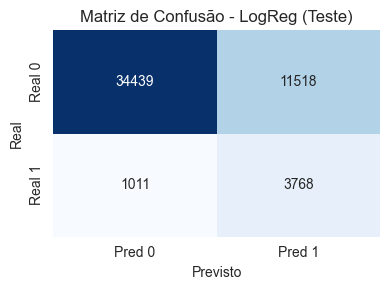

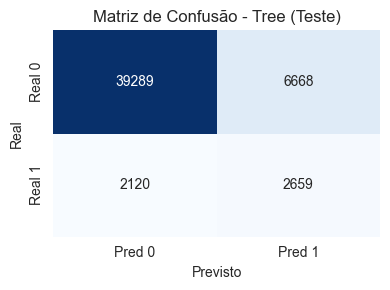

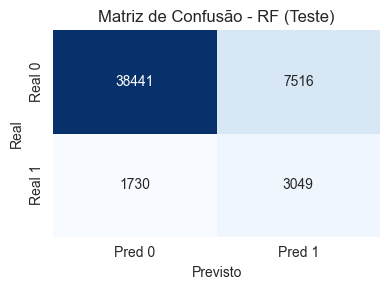

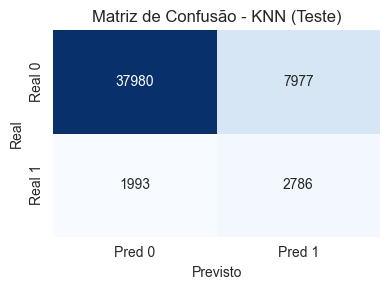

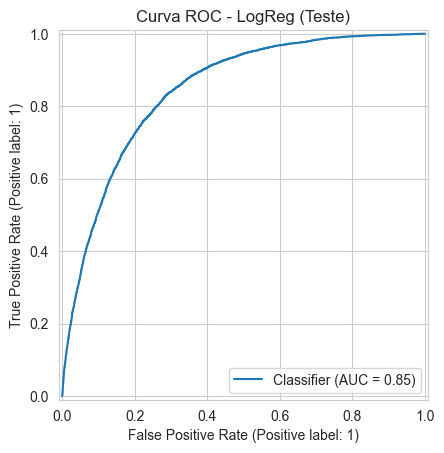

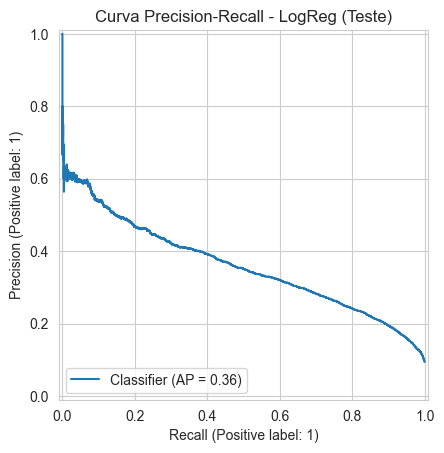

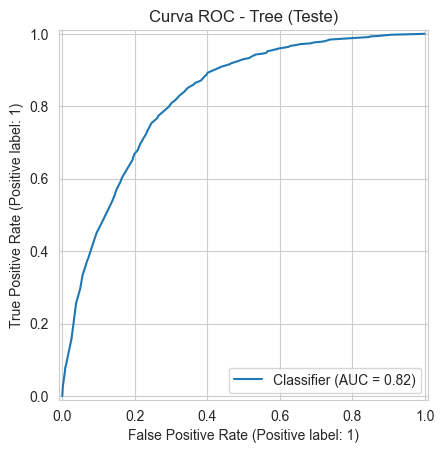

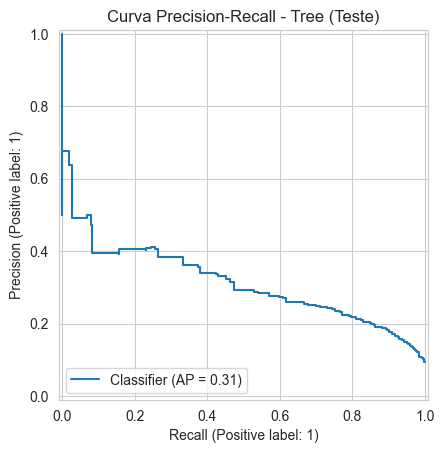

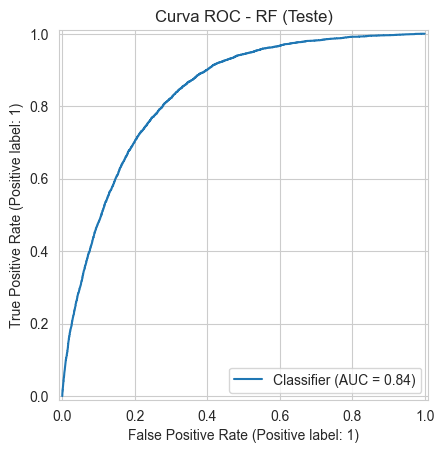

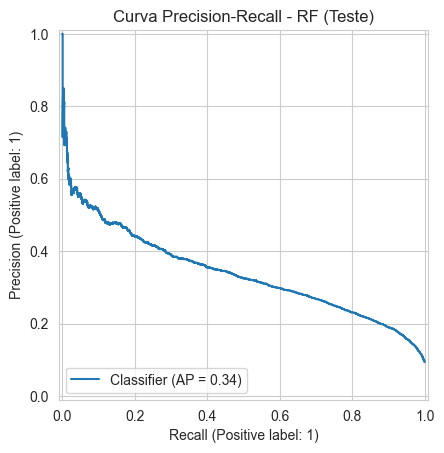

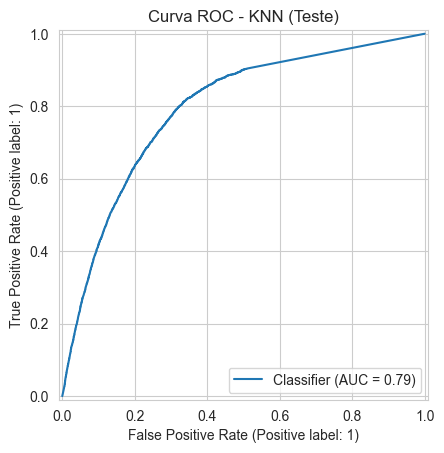

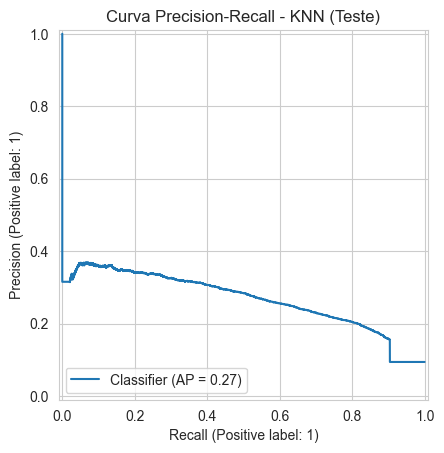

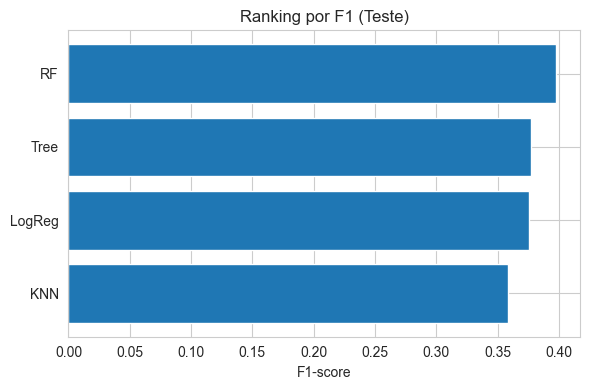

✅ Resultados gerados.


In [114]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

def eval_metrics(y_true, y_pred, y_proba):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    }

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0","Pred 1"], yticklabels=["Real 0","Real 1"])
    plt.title(title)
    plt.xlabel("Previsto"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

# ---------- Tabela final no TESTE ----------
test_rows = []
for name, model in best_models.items():
    yt_pred  = model.predict(X_test)
    yt_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    row = {"modelo": name}
    row.update(eval_metrics(y_test, yt_pred, yt_proba))
    test_rows.append(row)

test_df = (pd.DataFrame(test_rows)
           .sort_values("f1", ascending=False)
           .reset_index(drop=True))

print("\n=== Tabela-resumo das MÉTRICAS no TESTE ===")
display(test_df)

# (Opcional) salvar
# test_df.to_csv("resultados_teste.csv", index=False)

# ---------- Matrizes de confusão (TESTE) ----------
for name, model in best_models.items():
    yt_pred = model.predict(X_test)
    plot_cm(y_test, yt_pred, f"Matriz de Confusão - {name} (Teste)")

# ---------- Curvas ROC e Precision-Recall (TESTE) ----------
for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        yt_proba = model.predict_proba(X_test)[:,1]
        RocCurveDisplay.from_predictions(y_test, yt_proba)
        plt.title(f"Curva ROC - {name} (Teste)")
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_test, yt_proba)
        plt.title(f"Curva Precision-Recall - {name} (Teste)")
        plt.show()

# ---------- Ranking visual por F1 (TESTE) ----------
plt.figure(figsize=(6,4))
plt.barh(test_df["modelo"][::-1], test_df["f1"][::-1])
plt.title("Ranking por F1 (Teste)")
plt.xlabel("F1-score")
plt.tight_layout(); plt.show()

print("✅ Resultados gerados.")

**RandomForest (RF)** manteve o melhor F1 (0.397), confirmando o equilíbrio entre recall e precisão.O modelo também preservou um bom recall (0.64), o que demonstra boa capacidade de detectar casos positivos sem comprometer demais a precisão. É o modelo mais robusto e consistente entre validação e teste (queda mínima de F1 ≈ 0.01).

**DecisionTree** teve desempenho ligeiramente menor (F1=0.377) e recall inferior (~0.56). Apesar de mais simples e interpretável, mostrou menor estabilidade e tendência ao sobreajuste.

**LogisticRegression** novamente obteve o maior recall (0.79) e o melhor ROC-AUC (0.845), indicando ótima separabilidade entre classes, mas com precisão mais baixa (0.25) — ou seja, detecta bem, mas gera mais falsos positivos.
Ideal se o objetivo é não perder casos positivos.

KNN manteve desempenho inferior (F1=0.36, AUC=0.79), confirmando limitação em dados de alta dimensionalidade.

**O RandomForest é o melhor modelo geral, equilibrando recall e precisão, com boa estabilidade entre validação e teste → adequado para uso produtivo inicial. A LogisticRegression pode ser usada como alternativa quando a prioridade for sensibilidade máxima, aceitando mais falsos positivos.
Todos os modelos mantiveram ROC-AUC acima de 0.79, o que indica capacidade real de separação entre classes (bem acima do acaso).**

Uma análise sobre matrizes de confusão

Como as matrizes de confiusão permitem visualizar quantos casos o modelo classificou corretamente ou incorretamente:

**RandomForest (RF)** apresenta o melhor equilíbrio entre verdadeiros positivos (TP = 3.049) e falsos positivos (FP = 7.516).
Identifica bem os casos positivos (recall alto) e mantém controle de erros tipo I (precisão razoável).

**DecisionTree** tem comportamento parecido, mas com recall menor (2.659 TP) — indica perda de sensibilidade.

**LogisticRegression** detecta muito mais positivos (3.768 TP), porém gera muitos falsos positivos (11.518 FP).
Isso explica o recall mais alto e a precisão mais baixa — um bom modelo se a prioridade é não deixar casos passarem despercebidos, mesmo errando mais.

**KNN** fica entre RF e Tree, com menor recall e mais FP — reforçando sua limitação para dados de alta dimensão.

As curvas ROC mostram o trade-off entre taxa de verdadeiros positivos (sensibilidade) e falsos positivos.

RandomForest (AUC = 0.84) e LogisticRegression (AUC = 0.85) têm as maiores áreas sob a curva →
excelente poder de separação entre classes, indicando que ambos distinguem bem positivos e negativos.

DecisionTree (AUC = 0.82) também é bom, mas um pouco mais irregular.

KNN (AUC = 0.79) é o mais fraco, coerente com o F1 mais baixo.

Essas curvas são mais adequadas para problemas desbalanceados (como este, 9 % de positivos).
Elas mostram a relação direta entre recall e precisão.

LogisticRegression (AP = 0.36) tem a maior área sob a curva, reforçando sua alta sensibilidade — consegue capturar boa parte dos positivos, mesmo sacrificando precisão.

RandomForest (AP = 0.34) vem logo atrás, com melhor equilíbrio geral.

DecisionTree (AP = 0.31) e KNN apresentam queda acentuada de precisão quando o recall aumenta.

O RandomForest segue como o modelo mais equilibrado e robusto, ideal para uso prático.
Mantém ótimo desempenho em todos os indicadores e estabilidade entre treino, validação e teste.

A LogisticRegression é excelente para cenários de risco, onde é melhor “alertar em excesso” do que deixar casos passarem despercebidos.
Pode ser usada com ajuste de threshold (ex.: prever positivo quando probabilidade > 0.35 em vez de 0.5).

DecisionTree é mais simples e interpretável, útil como modelo de explicação.

KNN atua como baseline, mas sem bom ganho de performance.

## 8️⃣ Ajuste e thereshold

Justificativa do ajuste de threshold

O ajuste do threshold (limiar de decisão) é feito para encontrar o ponto ideal entre recall e precisão, adequando o comportamento do modelo ao objetivo do problema.

Por padrão, o modelo considera 0.5 como corte para classificar um caso como positivo, mas esse valor nem sempre representa o melhor equilíbrio — especialmente quando há desequilíbrio entre classes ou custos diferentes para falsos positivos e falsos negativos.

Assim, testamos vários thresholds (de 0.1 a 0.9) para identificar em qual ponto o modelo obtém o melhor F1-score, garantindo o melhor compromisso entre sensibilidade e precisão.

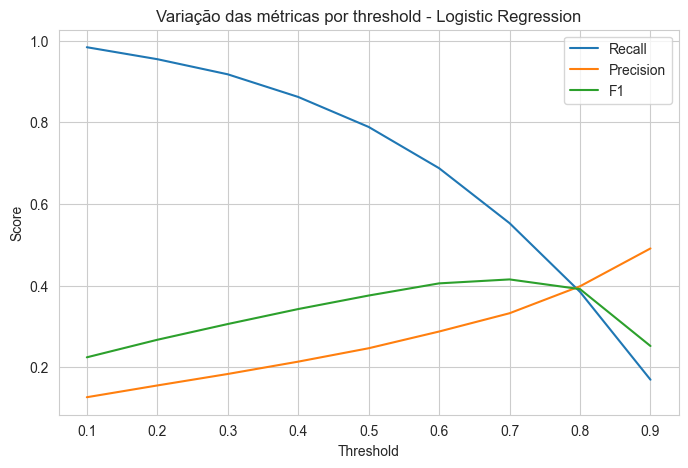

,threshold,accuracy,precision,recall,f1
0,0.1,0.359035,0.126565,0.983679,0.224274
1,0.2,0.506997,0.155369,0.954384,0.267233
2,0.3,0.607675,0.183477,0.917347,0.305793
3,0.4,0.688269,0.213696,0.861896,0.342479
4,0.5,0.753055,0.246500,0.788449,0.375579
5,0.6,0.810056,0.287452,0.687382,0.405380
6,0.7,0.853221,0.332243,0.552835,0.415050
7,0.8,0.887299,0.398267,0.384599,0.391314
8,0.9,0.905215,0.490909,0.169492,0.251983


Melhor threshold (maior F1): 0.70


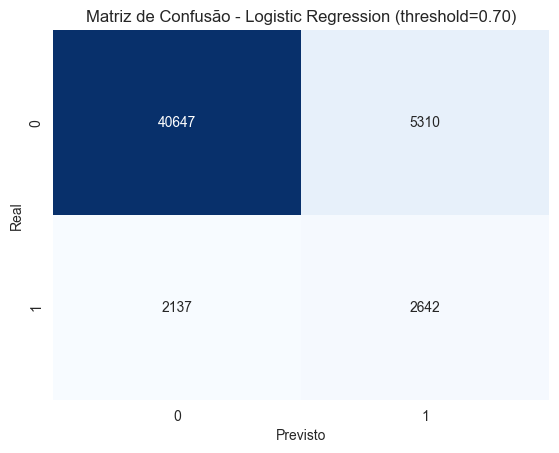

   Threshold  Accuracy  Precision    Recall       F1   ROC_AUC
0        0.7  0.853221   0.332243  0.552835  0.41505  0.845053


In [119]:
# Obtém probabilidades do modelo campeão
model_log = best_models["LogReg"]
y_proba = model_log.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.1, 0.9, 9)
metrics_list = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    metrics_list.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0)
    })

th_df = pd.DataFrame(metrics_list)

# --- gráfico
plt.figure(figsize=(8,5))
sns.lineplot(data=th_df, x="threshold", y="recall", label="Recall")
sns.lineplot(data=th_df, x="threshold", y="precision", label="Precision")
sns.lineplot(data=th_df, x="threshold", y="f1", label="F1")
plt.title("Variação das métricas por threshold - Logistic Regression")
plt.ylabel("Score")
plt.xlabel("Threshold")
plt.legend()
plt.show()

display(th_df)

# Escolha o threshold com melhor F1 (ou maior recall)
best_t = th_df.loc[th_df["f1"].idxmax(), "threshold"]
print(f"Melhor threshold (maior F1): {best_t:.2f}")

# Recalcula matriz de confusão com o novo threshold
y_pred_best = (y_proba >= best_t).astype(int)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Matriz de Confusão - Logistic Regression (threshold={best_t:.2f})")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# Métricas finais com o novo threshold
print(pd.DataFrame([{
    "Threshold": best_t,
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best, zero_division=0),
    "Recall": recall_score(y_test, y_pred_best, zero_division=0),
    "F1": f1_score(y_test, y_pred_best, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test, y_proba)
}]))

**O ajuste do threshold permitiu encontrar o ponto em que o modelo entrega o melhor equilíbrio entre precisão e recall.
O valor ideal foi 0.70, resultando em um F1 de 0.415 e ROC-AUC de 0.845, mostrando que o modelo mantém boa capacidade de separação entre as classes.**

Nesse ponto, o modelo se torna mais seletivo, reduzindo falsos positivos (maior precisão), mas ainda mantendo boa sensibilidade (recall ≈ 0.55).
Isso significa que ele classifica como “doente” apenas quando há alta confiança, equilibrando segurança e eficácia na detecção.

In [123]:
try:
    model_rf = best_models["RF"]
except Exception as e:
    print("best_models['RF'] não encontrado. Recrie o pipeline da RF com os melhores parâmetros do seu GridSearch.")
    raise

## 9️⃣ Feature Importance

,feature,importance
0,GenHlth,0.147528
1,Age,0.128451
2,HighBP_1,0.108401
3,HighBP_0,0.097961
4,HighChol_1,0.075590
5,HighChol_0,0.074802
6,DiffWalk_1,0.046421
7,PhysHlth,0.041916
8,DiffWalk_0,0.041691
9,Sex_0,0.037491


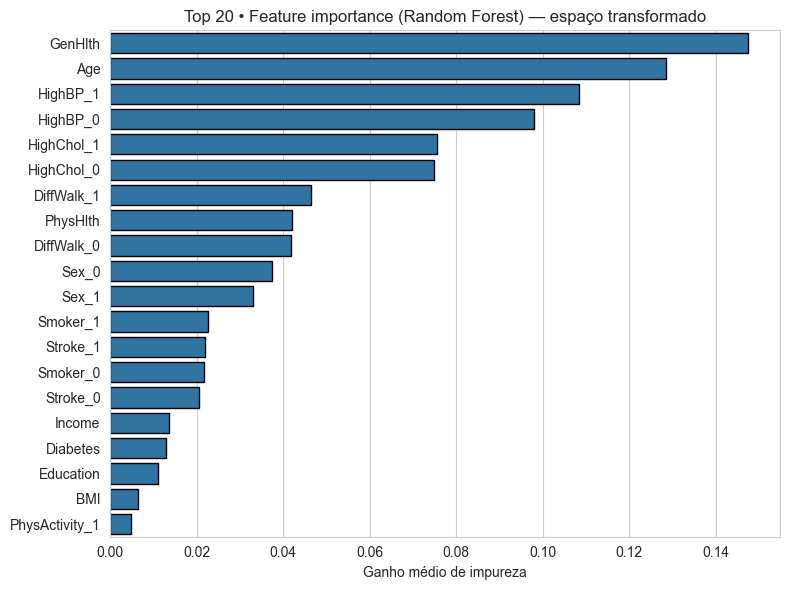

In [127]:
prep = model_rf.named_steps["prep"]
rf  = model_rf.named_steps["clf"]

feat_names_tr = prep.get_feature_names_out()

fi_raw = (
    pd.DataFrame({
        "feature": feat_names_tr,
        "importance": rf.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

display(fi_raw.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=fi_raw.head(20), y="feature", x="importance", edgecolor="black")
plt.title("Top 20 • Feature importance (Random Forest) — espaço transformado")
plt.xlabel("Ganho médio de impureza")
plt.ylabel("")
plt.tight_layout()
plt.show()

GenHlth e Age lideram: condição geral de saúde e idade são os sinais mais fortes.

HighBP (hipertensão) e HighChol (colesterol alto) têm peso alto — condiz com risco cardiovascular.

DiffWalk (dificuldade de caminhar) e PhysHlth (dias de saúde física ruim) também contribuem bastante.

Sexo, Smoker e Stroke aparecem relevantes; Income/Education surgem com menor impacto relativo.

BMI e PhysActivity entram, mas com importância menor no RF (o que não significa irrelevância clínica; apenas menor ganho de impureza neste modelo/feature set).

,feature,perm_importance,perm_std
18,Age,0.044728,0.001863
13,GenHlth,0.040056,0.001916
0,HighBP,0.032108,0.004082
17,Sex,0.029575,0.001163
1,HighChol,0.023873,0.002107
4,Smoker,0.008563,0.001417
5,Stroke,0.007989,0.000568
16,DiffWalk,0.006107,0.000734
15,PhysHlth,0.003378,0.000705
10,HvyAlcoholConsump,0.001657,0.000883


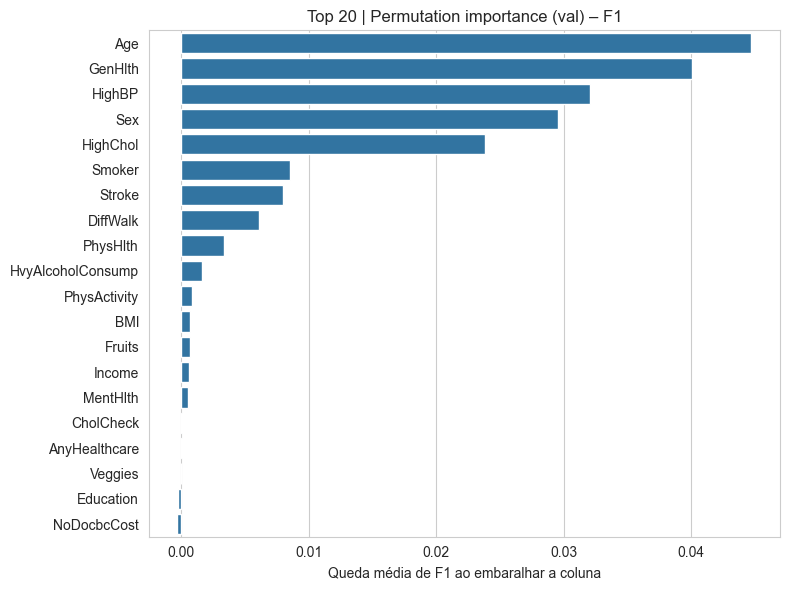

In [129]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model_rf, X_val, y_val,
    n_repeats=10, random_state=42, scoring="f1"
)

perm_df = pd.DataFrame({
    "feature": feature_names,
    "perm_importance": perm.importances_mean,
    "perm_std": perm.importances_std
}).sort_values("perm_importance", ascending=False)

display(perm_df.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=perm_df.head(20), y="feature", x="perm_importance")
plt.title("Top 20 | Permutation importance (val) – F1")
plt.xlabel("Queda média de F1 ao embaralhar a coluna")
plt.ylabel("")
plt.tight_layout()
plt.show()

O modelo identifica que fatores clínicos e de saúde geral são os mais relevantes para prever risco de doença cardíaca.

Idade (Age) e saúde geral percebida (GenHlth) são as variáveis com maior impacto sobre o desempenho do modelo.

Condições como pressão alta (HighBP) e colesterol elevado (HighChol) aparecem logo em seguida, reforçando sua importância médica.

Variáveis como sexo (Sex) e tabagismo (Smoker) também contribuem de forma significativa, embora com menor peso.

Fatores de estilo de vida (atividade física, consumo de álcool, dieta) e aspectos socioeconômicos (educação, renda) tiveram influência limitada no F1-score.

Os resultados confirmam que o modelo está coerente com o conhecimento clínico: idade e condições de saúde são os principais determinantes do risco cardíaco.

## 🔟 SHAP

Nesta etapa, o objetivo é entender por que o modelo tomou determinadas decisões em casos específicos do conjunto de teste.
Para isso, utilizaremos os gráficos waterfall do SHAP, que mostram como cada variável contribuiu positiva (vermelho) ou negativamente (azul) para a probabilidade prevista.

Serão escolhidos casos representativos para diferentes situações:

**Alto risco previsto** → entender o perfil de quem o modelo classifica com alta probabilidade de ter a doença.

**Próximo ao limiar (threshold)** → observar o comportamento do modelo em decisões mais incertas.

**Falso Negativo (FN)** → quando o modelo erra deixando de prever um caso positivo.

**Falso Positivo (FP)** → quando o modelo prevê doença em quem não tem.

Com isso, é possível interpretar individualmente as decisões e validar a coerência clínica e comportamental do modelo, além de identificar oportunidades de melhoria no threshold ou nas variáveis mais influentes.

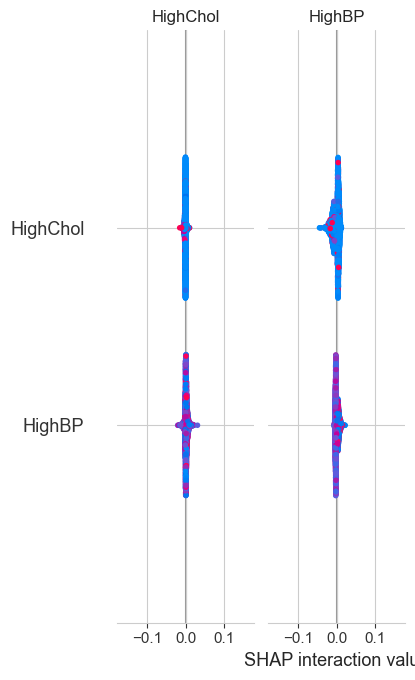

In [133]:
# 1) dados exatamente como o modelo vê
X_test_tr = model_rf.named_steps["prep"].transform(X_test)
X_test_tr = np.asarray(X_test_tr)  # garante array denso

rf_inner = model_rf.named_steps["clf"]
explainer = shap.TreeExplainer(rf_inner)

# amostra p/ performance (ajuste se quiser)
n = min(3000, X_test_tr.shape[0])
rng = np.random.RandomState(42)
idx_sample = rng.choice(X_test_tr.shape[0], n, replace=False)
X_shap = X_test_tr[idx_sample]

# 2) shap values (classes) -> pegamos da classe 1 (positivo)
sv = explainer.shap_values(X_shap)           # lista [classe0, classe1] em binário
sv1 = sv[1] if isinstance(sv, list) else sv  # matriz (n, n_features) ... às vezes (n, n_features+1)

# 3) correção de shape: remove coluna extra (offset) se existir
if sv1.shape[1] == X_shap.shape[1] + 1:
    sv1 = sv1[:, :-1]
elif sv1.shape[1] != X_shap.shape[1]:
    raise ValueError(f"SHAP shape mismatch: sv={sv1.shape}, X={X_shap.shape}")

# 4) summary plot (global)
shap.summary_plot(sv1, X_shap, feature_names=X.columns.tolist(), plot_size=(10,6))

Threshold usado para perfis: 0.70


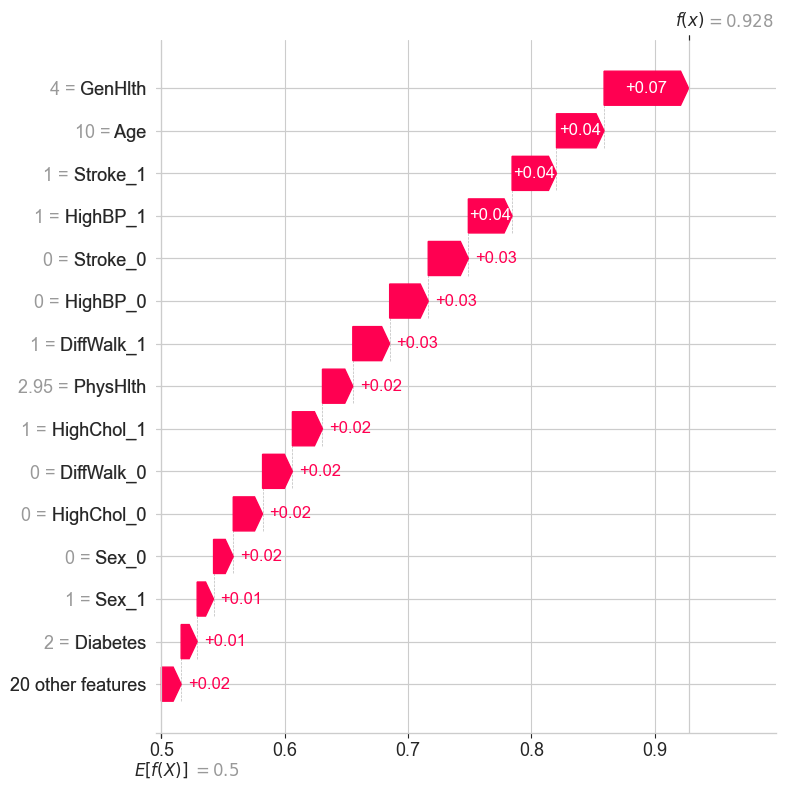


▶ Alto risco (p=0.928) | idx=20112


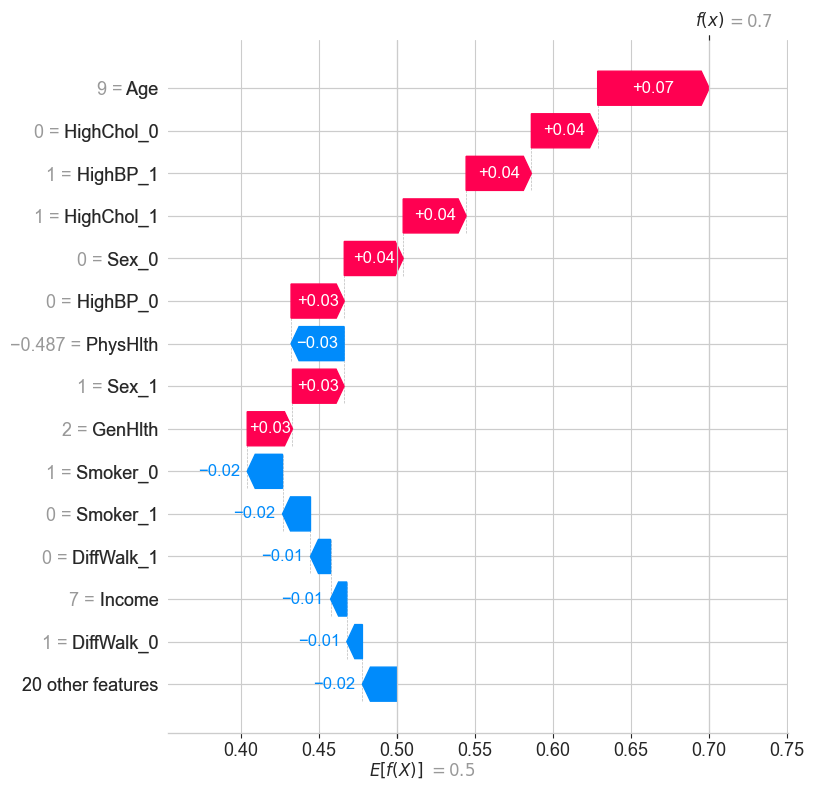


▶ Próximo ao threshold (p=0.700) | idx=24551


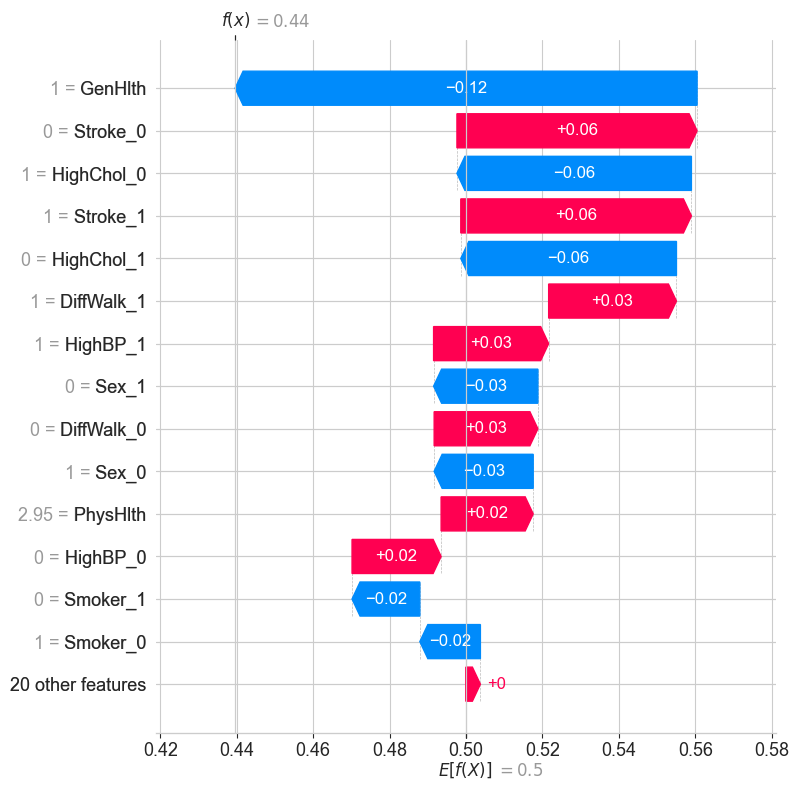


▶ Falso Negativo (p=0.440) | idx=13


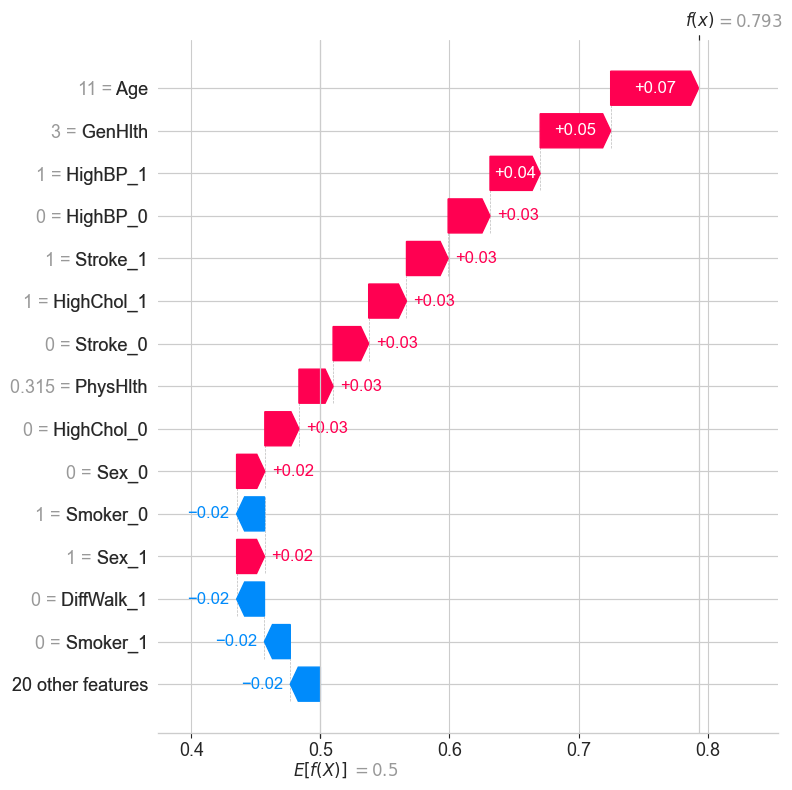


▶ Falso Positivo (p=0.793) | idx=35


In [137]:
# ==== Waterfalls SHAP para casos representativos ====
import numpy as np
import pandas as pd
import shap
import warnings

warnings.filterwarnings("ignore")

# 0) utilidades
def _make_explainer(model_rf):
    return shap.TreeExplainer(model_rf.named_steps["clf"])

def _feat_names_transformed(model_rf):
    return model_rf.named_steps["prep"].get_feature_names_out()

def _transform_row(model_rf, X, idx):
    x_one = model_rf.named_steps["prep"].transform(X.iloc[[idx]])
    return np.asarray(x_one)

def _waterfall_for_idx(model_rf, explainer, X, idx, title, max_display=15):
    x_one = _transform_row(model_rf, X, idx)
    feat_names = _feat_names_transformed(model_rf)

    # Tenta API moderna (Explanation)
    try:
        sv = explainer(x_one, check_additivity=False)  # -> shap.Explanation (1, n_features)
        try:
            shap.plots.waterfall(sv[0], max_display=max_display, show=True)
        except Exception:
            exp = shap.Explanation(
                values       = sv.values[0],
                base_values  = float(np.array(sv.base_values).ravel()[0]),
                data         = x_one[0],
                feature_names= feat_names
            )
            shap.waterfall_plot(exp, max_display=max_display, show=True)
    # Fallback API antiga
    except Exception:
        sv = explainer.shap_values(x_one, check_additivity=False)
        if isinstance(sv, list):    # lista [classe0, classe1]
            sv1 = sv[1]
        else:
            sv1 = sv
            if sv1.ndim == 3 and sv1.shape[-1] == 2:
                sv1 = sv1[:, :, 1]
        if sv1.ndim == 2 and sv1.shape[1] == x_one.shape[1] + 1:
            sv1 = sv1[:, :-1]
        values_1d = sv1[0]
        base = explainer.expected_value
        base = float(np.array(base).ravel()[-1])

        exp = shap.Explanation(
            values       = values_1d,
            base_values  = base,
            data         = x_one[0],
            feature_names= feat_names
        )
        try:
            shap.plots.waterfall(exp, max_display=max_display, show=True)
        except Exception:
            shap.waterfall_plot(exp, max_display=max_display, show=True)

    print(f"\n▶ {title} | idx={idx}")

# 1) probabilidades no teste (usaremos o modelo RF para os perfis)
proba = model_rf.predict_proba(X_test)[:, 1]

# threshold: usa best_t se existir; senão 0.50 (ou ajuste)
try:
    thr = float(best_t)
except NameError:
    thr = 0.70  # mude se quiser usar o threshold otimizado que você escolheu
print(f"Threshold usado para perfis: {thr:.2f}")

y_pred_thr = (proba >= thr).astype(int)

# 2) seleções de casos
idx_high = int(np.argmax(proba))                                 # maior risco previsto
idx_thr  = int(np.argmin(np.abs(proba - thr)))                    # mais perto do limiar
fn_idx   = np.where((y_test.values == 1) & (y_pred_thr == 0))[0]  # falsos negativos
fp_idx   = np.where((y_test.values == 0) & (y_pred_thr == 1))[0]  # falsos positivos
idx_fn   = int(fn_idx[0]) if len(fn_idx) else None
idx_fp   = int(fp_idx[0]) if len(fp_idx) else None

# 3) explainer
explainer = _make_explainer(model_rf)

# 4) plota waterfalls
_waterfall_for_idx(model_rf, explainer, X_test, idx_high, f"Alto risco (p={proba[idx_high]:.3f})")
_waterfall_for_idx(model_rf, explainer, X_test, idx_thr,  f"Próximo ao threshold (p={proba[idx_thr]:.3f})")

if idx_fn is not None:
    _waterfall_for_idx(model_rf, explainer, X_test, idx_fn,   f"Falso Negativo (p={proba[idx_fn]:.3f})")
else:
    print("Sem FN com esse threshold.")

if idx_fp is not None:
    _waterfall_for_idx(model_rf, explainer, X_test, idx_fp,   f"Falso Positivo (p={proba[idx_fp]:.3f})")
else:
    print("Sem FP com esse threshold.")


**Caso 1 — Alto risco previsto (f(x) ≈ 0.93**

O modelo atribuiu uma alta probabilidade de doença.
As variáveis que mais aumentaram o risco foram:

GenHlth (autoavaliação de saúde ruim)
Idade elevada (Age)
Histórico de AVC (Stroke)
Hipertensão (HighBP) e Colesterol alto (HighChol)
Dificuldade para caminhar (DiffWalk) e problemas físicos (PhysHlth)
Essas características reforçam um perfil de alto risco cardiovascular, e o modelo respondeu de forma coerente ao identificar múltiplos fatores de saúde debilitada.

**Caso 2 — Próximo ao threshold (f(x) ≈ 0.70)**

Aqui o indivíduo está no limite de decisão — o modelo quase o classificou como positivo.
Contribuições positivas: idade, colesterol e pressão altos.
Contribuições negativas: bom estado físico (PhysHlth menor) e ausência de tabagismo.
Isso mostra um caso “intermediário”, em que pequenos ajustes no threshold poderiam mudar o resultado da previsão.

**Caso 3 — Falso Negativo (f(x) ≈ 0.44)**

O modelo previu baixo risco, mas o caso era de fato positivo.
O fator que mais reduziu a probabilidade foi GenHlth = 1, indicando boa saúde autodeclarada — o que enganou o modelo.
Por outro lado, havia presença de AVC, hipertensão e colesterol alto, que deveriam ter aumentado o risco.
Esse caso ilustra como autopercepções positivas podem mascarar riscos clínicos reais, explicando a falha do modelo.

**Caso 4 — Falso Positivo (f(x) ≈ 0.79)**

O modelo classificou como positivo quem não tinha a doença.
Os principais fatores que aumentaram a previsão foram idade, saúde ruim e hipertensão, todos de risco.
Entretanto, a ausência de sintomas graves (como tabagismo e dificuldade de locomoção) reduziu o valor, mas não o suficiente.
Isso sugere que, em pessoas mais velhas e hipertensas, o modelo tende a superestimar o risco.

**Conclusão geral**

As análises locais do SHAP mostram que o modelo se comporta de forma coerente:
Dá mais peso a indicadores clínicos fortes (GenHlth, Age, HighBP, HighChol, Stroke).
Ainda comete erros quando há informações contraditórias (boa saúde relatada × condições clínicas).
Essas visualizações ajudam a interpretar e auditar decisões individuais, identificando onde o modelo pode ser ajustado — por exemplo, calibrando o threshold ou reforçando variáveis de saúde objetiva.